In [1]:
from torch.utils.data import DataLoader
from datasets.Dataset_Bend_H import Dataset_Bend_H, plot_ds
from models.UNet import UNet
from training.Trainer_Dipole_H import Trainer_Dipole_H
import torch
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [2]:
# dataset parameters
# dataset_path = "../data/raw/npz_select_1cmSpacing"
dataset_path = "../data/bend_h/prepared"
mdfile = "md_hshaped_v1"
# maximum_elements = 19200
# maximum_elements = 2560
maximum_elements = 200
traintestsplit = 0.9

# hyperparameters
# batch_size = 64
batch_size = 8
learning_rate = 0.001
num_epochs = 150
depth = 5
wf = 4
padding = True
up_mode = 'upconv'
drop_out = 0

# load dataset
# dataset = Dataset_Dipole_H(dataset_path, maximum_elements=maximum_elements, mdfile=mdfile, prepareFolder="prepared_v1_weighted_o1")
dataset = Dataset_Bend_H(dataset_path, maximum_elements=maximum_elements)
print("Dataset loaded")
# dataset.prepare_all(overwrite=True)
# print("Dataset prepared")


Dataset loaded


In [3]:

# split dataset into train and test
train_dataset, test_dataset = torch.utils.data.Subset(dataset, range(0, int(len(dataset)*(1-traintestsplit)))), torch.utils.data.Subset(dataset, range(int(len(dataset)*(1-traintestsplit)), len(dataset)))
# train_dataset, test_dataset = torch.utils.data.random_split(dataset, [len(dataset) - int(len(dataset)*traintestsplit), int(len(dataset)*traintestsplit)])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print(len(train_loader))
print(len(test_loader))

# set device
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print("Using", device)

# load model
model = UNet(in_channels=18, out_channels=2, depth=depth, wf=wf, padding=padding, batch_norm=True, up_mode=up_mode, drop_out=drop_out)
print(model)

# set optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(optimizer)

# set criterion
criterion = torch.nn.MSELoss()
print(criterion)

# create trainer
trainer = Trainer_Dipole_H(model, optimizer, criterion, device)
print("Trainer created")

# load model
# trainer.load_model("../UNet_Dipole_H.pt")
# trainer.load_model("../models_trained/model_UNet_outer0/UNet_Dipole_H.pt")
trainer.load_model("../UNet_Dipole_H_v2_epoch0012.pt")
print("Model loaded")


1
6
Using mps
UNet(
  (down_path): ModuleList(
    (0): UNetConvBlock(
      (block): Sequential(
        (0): Conv2d(18, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): LeakyReLU(negative_slope=0.01)
        (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): UNetConvBlock(
      (block): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): LeakyReLU(negative_slope=0.01)
        (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True,

In [4]:
# model.load_state_dict(torch.load("../models_trained/model_UNet_outer0/UNet_Dipole_H.pt"))
model.eval()

UNet(
  (down_path): ModuleList(
    (0): UNetConvBlock(
      (block): Sequential(
        (0): Conv2d(18, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): LeakyReLU(negative_slope=0.01)
        (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): UNetConvBlock(
      (block): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): LeakyReLU(negative_slope=0.01)
        (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running

torch.Size([8, 2, 224, 160])
torch.Size([8, 2, 224, 160])
torch.Size([8, 18, 224, 160])
Batch: 1
Sample: 0


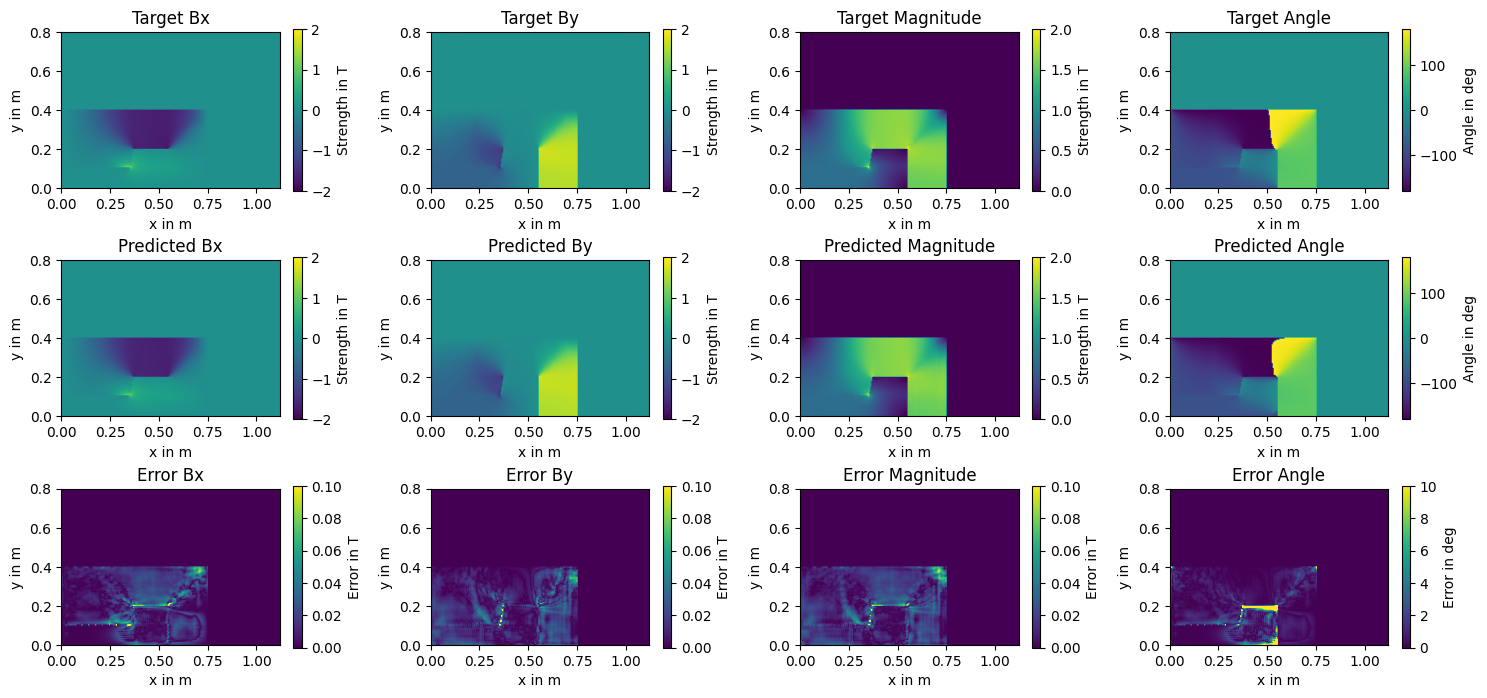

In [49]:
# test model
for i, (x, y) in enumerate(test_loader):
    
    if i == 1:
    # for sample in range(0, 8):
        sample = 0
        x = x.to(device, dtype=torch.float32)
        y = y.to(device, dtype=torch.float32)
        with torch.no_grad():
            y_pred = model(x)
        print(y_pred.shape)
        print(y.shape)
        print(x.shape)
        prio = x[sample, 17, :, :].cpu().detach().numpy().T
        tar_x = y[sample, 0, :, :].cpu().detach().numpy().T
        tar_y = y[sample, 1, :, :].cpu().detach().numpy().T
        pred_x = y_pred[sample, 0, :, :].cpu().detach().numpy().T
        pred_y = y_pred[sample, 1, :, :].cpu().detach().numpy().T
        boolprio = prio > 0

        tar_x = tar_x * boolprio
        tar_y = tar_y * boolprio
        pred_x = pred_x * boolprio
        pred_y = pred_y * boolprio

        # interpret x and y as strength for a vector field in x and y direction - calculate the magnitude and the angle
        tar_mag = np.sqrt(tar_x**2 + tar_y**2)
        tar_ang = np.arctan2(tar_y, tar_x) * boolprio
        pred_mag = np.sqrt(pred_x**2 + pred_y**2)
        pred_ang = np.arctan2(pred_y, pred_x) * boolprio

        # calculate the error
        error_x = np.abs(tar_x - pred_x)
        error_y = np.abs(tar_y - pred_y)
        error_mag = np.abs(tar_mag - pred_mag)
        error_ang = np.abs(np.mod(tar_ang - pred_ang + np.pi, 2*np.pi) - np.pi)

        fig, ax = plt.subplots(3, 4, figsize=(15,7))

        def plot_field(ax, field, title, vmin, vmax, zlabel):
            img = ax.imshow(field, origin='lower', vmin=vmin, vmax=vmax, extent=[0.0, tar_x.shape[1]*0.005, 0.0, tar_x.shape[0]*0.005])
            ax.set_title(title)
            ax.set_xlabel("x in m")
            ax.set_ylabel("y in m")
            # add colorbar
            # reduce the size of the colorbar
            ax.set_aspect('equal')
            cbar = ax.figure.colorbar(img, ax=ax, shrink=1.0)
            cbar.set_label(zlabel)

        fields = [tar_x, tar_y, tar_mag, tar_ang*180/np.pi, pred_x, pred_y, pred_mag, pred_ang*180/np.pi, error_x, error_y, error_mag, error_ang*180/np.pi]
        titles = ["Target Bx", "Target By", "Target Magnitude", "Target Angle", "Predicted Bx", "Predicted By", "Predicted Magnitude", "Predicted Angle", "Error Bx", "Error By", "Error Magnitude", "Error Angle"]
        vmins = [-2, -2, 0, -180, -2, -2, 0, -180, 0, 0, 0, 0]
        # vmaxs = [2, 2, 2, 180, 2, 2, 2, 180, 0.05, 0.05, 0.05, 10]
        vmaxs = [2, 2, 2, 180, 2, 2, 2, 180, 0.1, 0.1, 0.1, 10]
        zlabels = ["Strength in T", "Strength in T", "Strength in T", "Angle in deg", "Strength in T", "Strength in T", "Strength in T", "Angle in deg", "Error in T", "Error in T", "Error in T", "Error in deg"]

        for idx in range(12):
            plot_field(ax[idx//4, idx%4], fields[idx], titles[idx], vmins[idx], vmaxs[idx], zlabels[idx])

        print("Batch:", i)
        print("Sample:", sample)
        fig.tight_layout()
        fig.savefig("bend_h_v2_thesis_batch" + str(i) + "_sample" + str(sample) + "_010.png")
        fig.savefig("bend_h_v2_thesis_batch" + str(i) + "_sample" + str(sample) + "_010.pdf")
        # fig.savefig("bend_h_v2_thesis_batch" + str(i) + "_sample" + str(sample) + "_005.png")
        # fig.savefig("bend_h_v2_thesis_batch" + str(i) + "_sample" + str(sample) + "_005.pdf")
        plt.show()
        # break

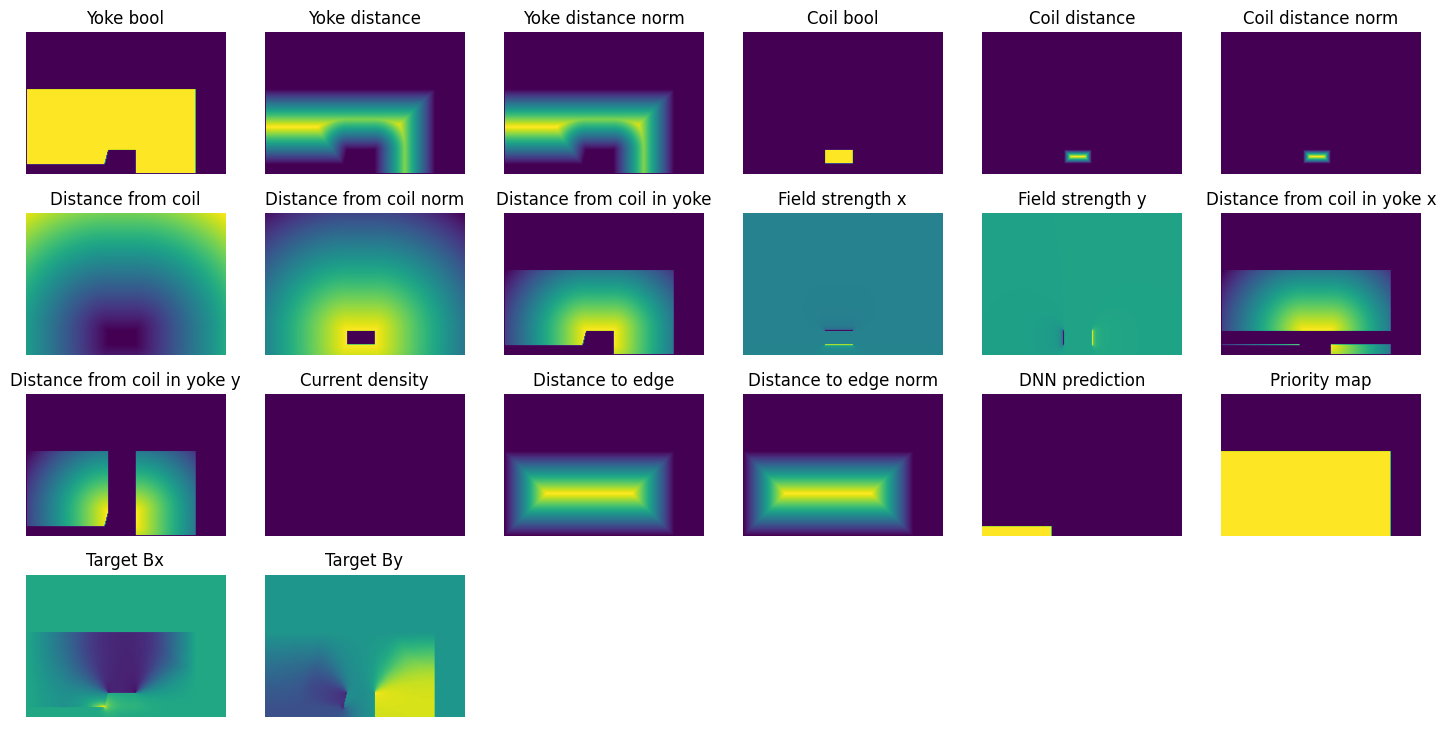

In [48]:
def plot_to_axis(axs, img, title):
    axs.imshow(img.T, origin='lower')
    axs.set_title(title)
    axs.set_aspect('equal')
    axs.axis('off')

def plot_ds(ds, idx):
    inp, tar = ds[idx]
    fig, axs = plt.subplots(4, 6, figsize=(18, 9))
    plot_to_axis(axs[0, 0], inp[0,:,:], "Yoke bool")
    plot_to_axis(axs[0, 1], inp[1,:,:], "Yoke distance")
    plot_to_axis(axs[0, 2], inp[2,:,:], "Yoke distance norm")
    plot_to_axis(axs[0, 3], inp[3,:,:], "Coil bool")
    plot_to_axis(axs[0, 4], inp[4,:,:], "Coil distance")
    plot_to_axis(axs[0, 5], inp[5,:,:], "Coil distance norm")
    plot_to_axis(axs[1, 0], inp[6,:,:], "Distance from coil")
    plot_to_axis(axs[1, 1], inp[7,:,:], "Distance from coil norm")
    plot_to_axis(axs[1, 2], inp[8,:,:], "Distance from coil in yoke")
    plot_to_axis(axs[1, 3], inp[9,:,:], "Field strength x")
    plot_to_axis(axs[1, 4], inp[10,:,:], "Field strength y")
    plot_to_axis(axs[1, 5], inp[11,:,:], "Distance from coil in yoke x")
    plot_to_axis(axs[2, 0], inp[12,:,:], "Distance from coil in yoke y")
    plot_to_axis(axs[2, 1], inp[13,:,:], "Current density")
    plot_to_axis(axs[2, 2], inp[14,:,:], "Distance to edge")
    plot_to_axis(axs[2, 3], inp[15,:,:], "Distance to edge norm")
    plot_to_axis(axs[2, 4], inp[16,:,:], "DNN prediction")
    plot_to_axis(axs[2, 5], inp[17,:,:], "Priority map")
    plot_to_axis(axs[3, 0], tar[0,:,:], "Target Bx")
    plot_to_axis(axs[3, 1], tar[1,:,:], "Target By")
    axs[3, 2].axis('off')
    axs[3, 3].axis('off')
    axs[3, 4].axis('off')
    axs[3, 5].axis('off')
    # fig.tight_layout()
    fig.savefig("dataset_unet_example.png")
    fig.savefig("dataset_unet_example.pdf")
    plt.show()

plot_ds(dataset, 14)

In [7]:
def get_metrics(arr):
    if type(arr) == int:
        arr = np.array([arr])
    # Flatten the 2D array to 1D
    flattened_array = arr.flatten()
    # Filter out the zero values
    
    if len(flattened_array[flattened_array != 0]) > 0:
        non_zero_values = flattened_array[flattened_array != 0]
    else:
        non_zero_values = flattened_array
    # Calculate mean, median, and max
    mean_value = np.mean(non_zero_values)
    median_value = np.median(non_zero_values)
    max_value = np.max(non_zero_values)
    # Calculate the 95th percentile
    perc95 = np.percentile(non_zero_values, 95)
    return mean_value, median_value, max_value, perc95, 1

def get_errors(model, test_loader, figureOfMerit="all", metric="mean", norm=None):
    # create a histogram that shows the mean error for each sample
    error_x = []
    error_y = []
    error_mag = []
    error_ang = []
    for i, (x, y) in enumerate(test_loader):
        x = x.to(device, dtype=torch.float32)
        y = y.to(device, dtype=torch.float32)
        
        for sample in range(x.shape[0]):
            if figureOfMerit == "all":
                mask = x[sample, 17, :, :] > 0
            elif figureOfMerit == "aperture":
                mask = x[sample, 16, :, :] > 0
            elif figureOfMerit == "yoke":
                mask = x[sample, 0, :, :] > 0
            elif figureOfMerit == "coil":
                mask = x[sample, 3, :, :] > 0
            elif figureOfMerit == "rest":
                mask = (x[sample, 17, :, :] > 0) * (x[sample, 16, :, :] == 0) * (x[sample, 0, :, :] == 0) * (x[sample, 3, :, :] == 0)
            else:
                raise ValueError("Unknown figure of merit")
            mask = mask.cpu().detach().numpy().T

            with torch.no_grad():
                y_pred = model(x)
            tar_x = y[sample, 0, :, :].cpu().detach().numpy().T
            tar_y = y[sample, 1, :, :].cpu().detach().numpy().T
            pred_x = y_pred[sample, 0, :, :].cpu().detach().numpy().T
            pred_y = y_pred[sample, 1, :, :].cpu().detach().numpy().T
                
            tar_mag = np.sqrt(tar_x**2 + tar_y**2)
            tar_ang = np.arctan2(tar_y, tar_x)
            pred_mag = np.sqrt(pred_x**2 + pred_y**2)
            pred_ang = np.arctan2(pred_y, pred_x)

            tar_x = tar_x * mask
            tar_y = tar_y * mask
            pred_x = pred_x * mask
            pred_y = pred_y * mask
            tar_mag = tar_mag * mask
            tar_ang = tar_ang * mask
            pred_mag = pred_mag * mask
            pred_ang = pred_ang * mask
            
            # calculate the error
            err_x = np.abs(tar_x - pred_x)
            err_y = np.abs(tar_y - pred_y)
            err_mag = np.abs(tar_mag - pred_mag)
            err_ang = np.abs(np.mod(tar_ang - pred_ang + np.pi, 2*np.pi) - np.pi)

            if norm == "all":
                err_x = np.abs(np.divide(err_x, tar_x))
                err_y = np.abs(np.divide(err_y, tar_y))
                err_mag = np.abs(np.divide(err_mag, tar_mag))
                err_ang = np.abs(np.divide(err_ang, tar_ang))
            elif norm == "max":
                err_x = err_x / np.max(np.abs(tar_x))
                err_y = err_y / np.max(np.abs(tar_y))
                err_mag = err_mag / np.max(np.abs(tar_mag))
                err_ang = err_ang / np.max(np.abs(tar_ang))
            elif norm == "zero":
                err_x = err_x / np.abs(tar_x[0,0]) if tar_x[0,0] != 0 else 0
                err_y = err_y / np.abs(tar_y[0,0]) if tar_y[0,0] != 0 else 0
                err_mag = err_mag / np.abs(tar_mag[0,0]) if tar_mag[0,0] != 0 else 0
                err_ang = err_ang / np.abs(tar_ang[0,0]) if tar_ang[0,0] != 0 else 0
            elif norm == "zeroonly":
                err_x = np.array([err_x[0,0] / np.abs(tar_x[0,0])]) if tar_x[0,0] != 0 else 0
                err_y = np.array([err_y[0,0] / np.abs(tar_y[0,0])]) if tar_y[0,0] != 0 else 0
                err_mag = np.array([err_mag[0,0] / np.abs(tar_mag[0,0])]) if tar_mag[0,0] != 0 else 0
                err_ang = np.array([err_ang[0,0] / np.abs(tar_ang[0,0])]) if tar_ang[0,0] != 0 else 0
            else:
                pass

            # # plot mask
            # img = plt.imshow(err_x, origin='lower', vmin=0, vmax=0.1)
            # plt.colorbar(img)
            # plt.show()
            
            # get metrics
            mean_x, median_x, max_x, perc95_x, bvc_x = get_metrics(err_x)
            mean_y, median_y, max_y, perc95_y, bvc_y = get_metrics(err_y)
            mean_mag, median_mag, max_mag, perc95_mag, bvc_mag = get_metrics(err_mag)
            mean_ang, median_ang, max_ang,perc95_ang, bvc_ang = get_metrics(err_ang)

            if metric=="mean":
                error_x.append(mean_x)
                error_y.append(mean_y)
                error_mag.append(mean_mag)
                error_ang.append(mean_ang)
            elif metric=="median":
                error_x.append(median_x)
                error_y.append(median_y)
                error_mag.append(median_mag)
                error_ang.append(median_ang)
            elif metric=="max":
                error_x.append(max_x)
                error_y.append(max_y)
                error_mag.append(max_mag)
                error_ang.append(max_ang)
            elif metric=="perc95":
                error_x.append(perc95_x)
                error_y.append(perc95_y)
                error_mag.append(perc95_mag)
                error_ang.append(perc95_ang)
            elif metric=="bvc":
                error_x.append(bvc_x)
                error_y.append(bvc_y)
                error_mag.append(bvc_mag)
                error_ang.append(bvc_ang)
            else:
                raise ValueError("Unknown metric")
            

    error_x = np.array(error_x)
    error_y = np.array(error_y)
    error_mag = np.array(error_mag)
    error_ang = np.array(error_ang)
    return error_x, error_y, error_mag, error_ang

In [8]:
def plot_histogram(ax, data, title, bins, range):
    ax.set_xlim(range)
    counts, bin_edges = np.histogram(data, bins=bins, range=range)
    ax.set_title(title)
    ax.set_xlabel("Mean Error")
    ax.set_ylabel("Frequency")
    ax.set_yscale("log")
    bin_centres = (bin_edges[:-1] + bin_edges[1:]) * 0.5
    err = np.sqrt(counts)
    ax.errorbar(bin_centres, counts, yerr=err, fmt='o')

def plot_histograms(error_x, error_y, error_mag, error_ang):
    fig, ax = plt.subplots(2, 2, figsize=(30, 10))
    plot_histogram(ax[0, 0], error_x, "Error X", 50, (0, 0.5))
    plot_histogram(ax[0, 1], error_y, "Error Y", 50, (0, 0.5))
    plot_histogram(ax[1, 0], error_mag, "Error Magnitude", 50, (0, 0.5))
    plot_histogram(ax[1, 1], error_ang, "Error Angle", 180, (0, np.pi))
    plt.show()

def getErrorHistograms(model, test_loader, figureOfMerit="all", metric="mean", norm=None):
    print("-------------------------")
    print(figureOfMerit)
    error_x, error_y, error_mag, error_ang = get_errors(model, test_loader, figureOfMerit, metric, norm)
    plot_histograms(error_x, error_y, error_mag, error_ang)
    print(metric, " error x:", np.mean(error_x))
    print(metric, " error y:", np.mean(error_y))
    print(metric, " error magnitude:", np.mean(error_mag))
    print(metric, " error angle:", np.mean(error_ang))
    # print(metric, " error x std:", np.std(error_x))
    # print(metric, " error y std:", np.std(error_y))
    # print(metric, " error magnitude std:", np.std(error_mag))
    # print(metric, " error angle std:", np.std(error_ang))


-------------------------
yoke


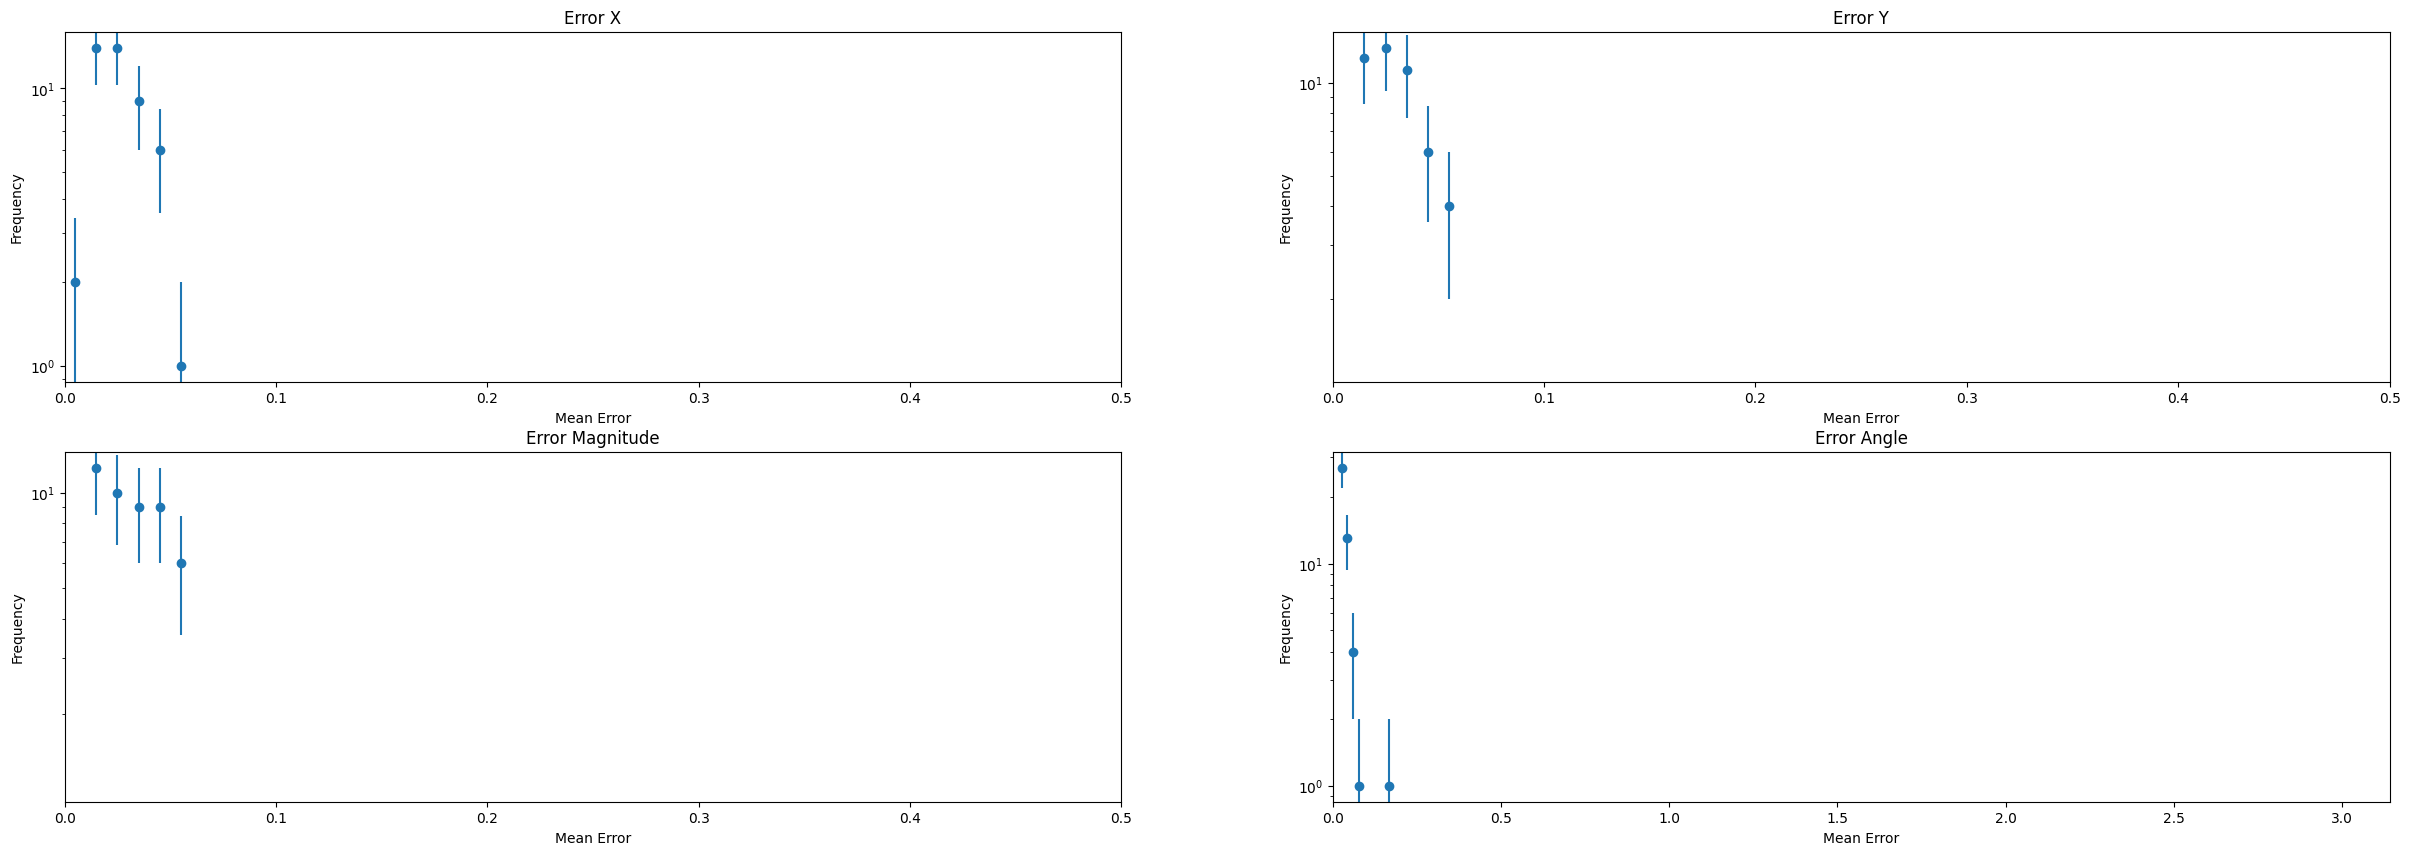

perc95  error x: 0.026111782574013833
perc95  error y: 0.029867164499085875
perc95  error magnitude: 0.03205512592002101
perc95  error angle: 0.03865692485933717


In [9]:
getErrorHistograms(model, test_loader, figureOfMerit="yoke", metric="perc95")

-------------------------
all


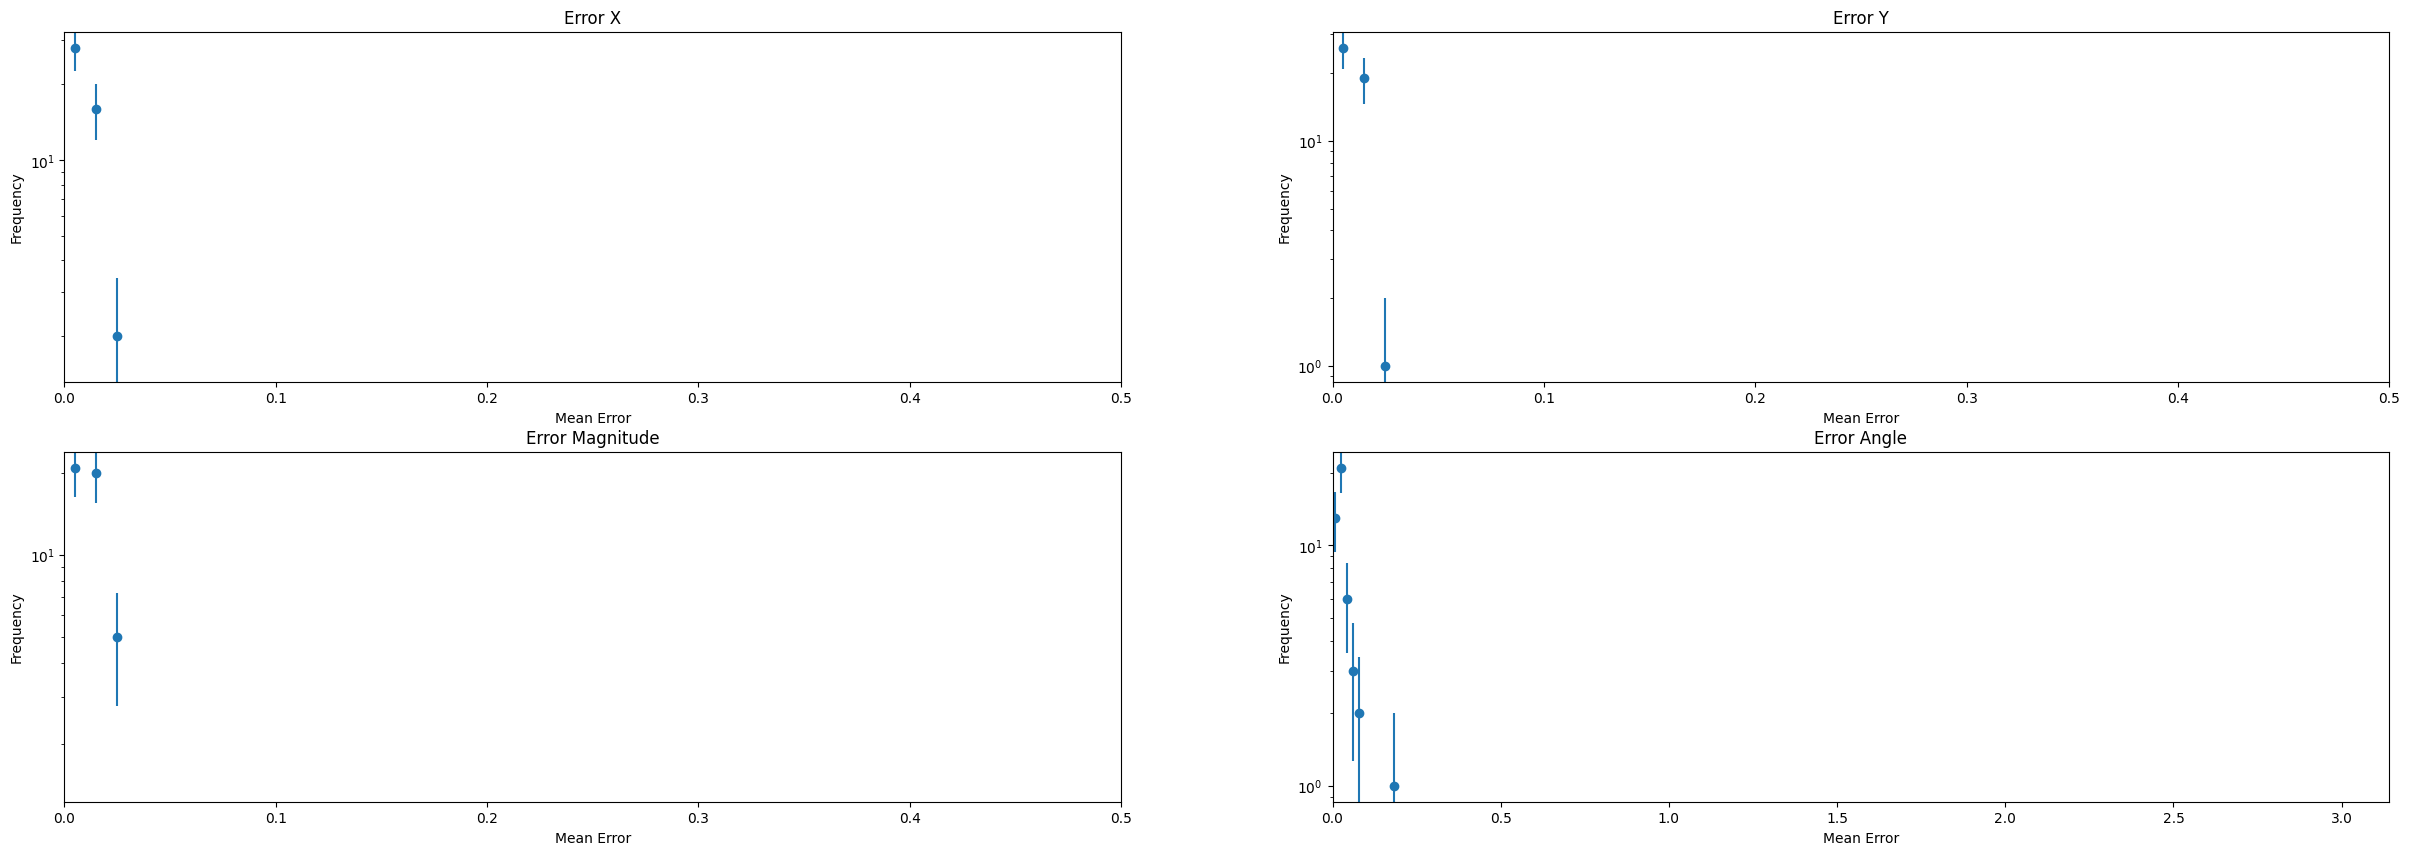

mean  error x: 0.009432138
mean  error y: 0.009841136
mean  error magnitude: 0.012160722
mean  error angle: 0.032035597
-------------------------
aperture


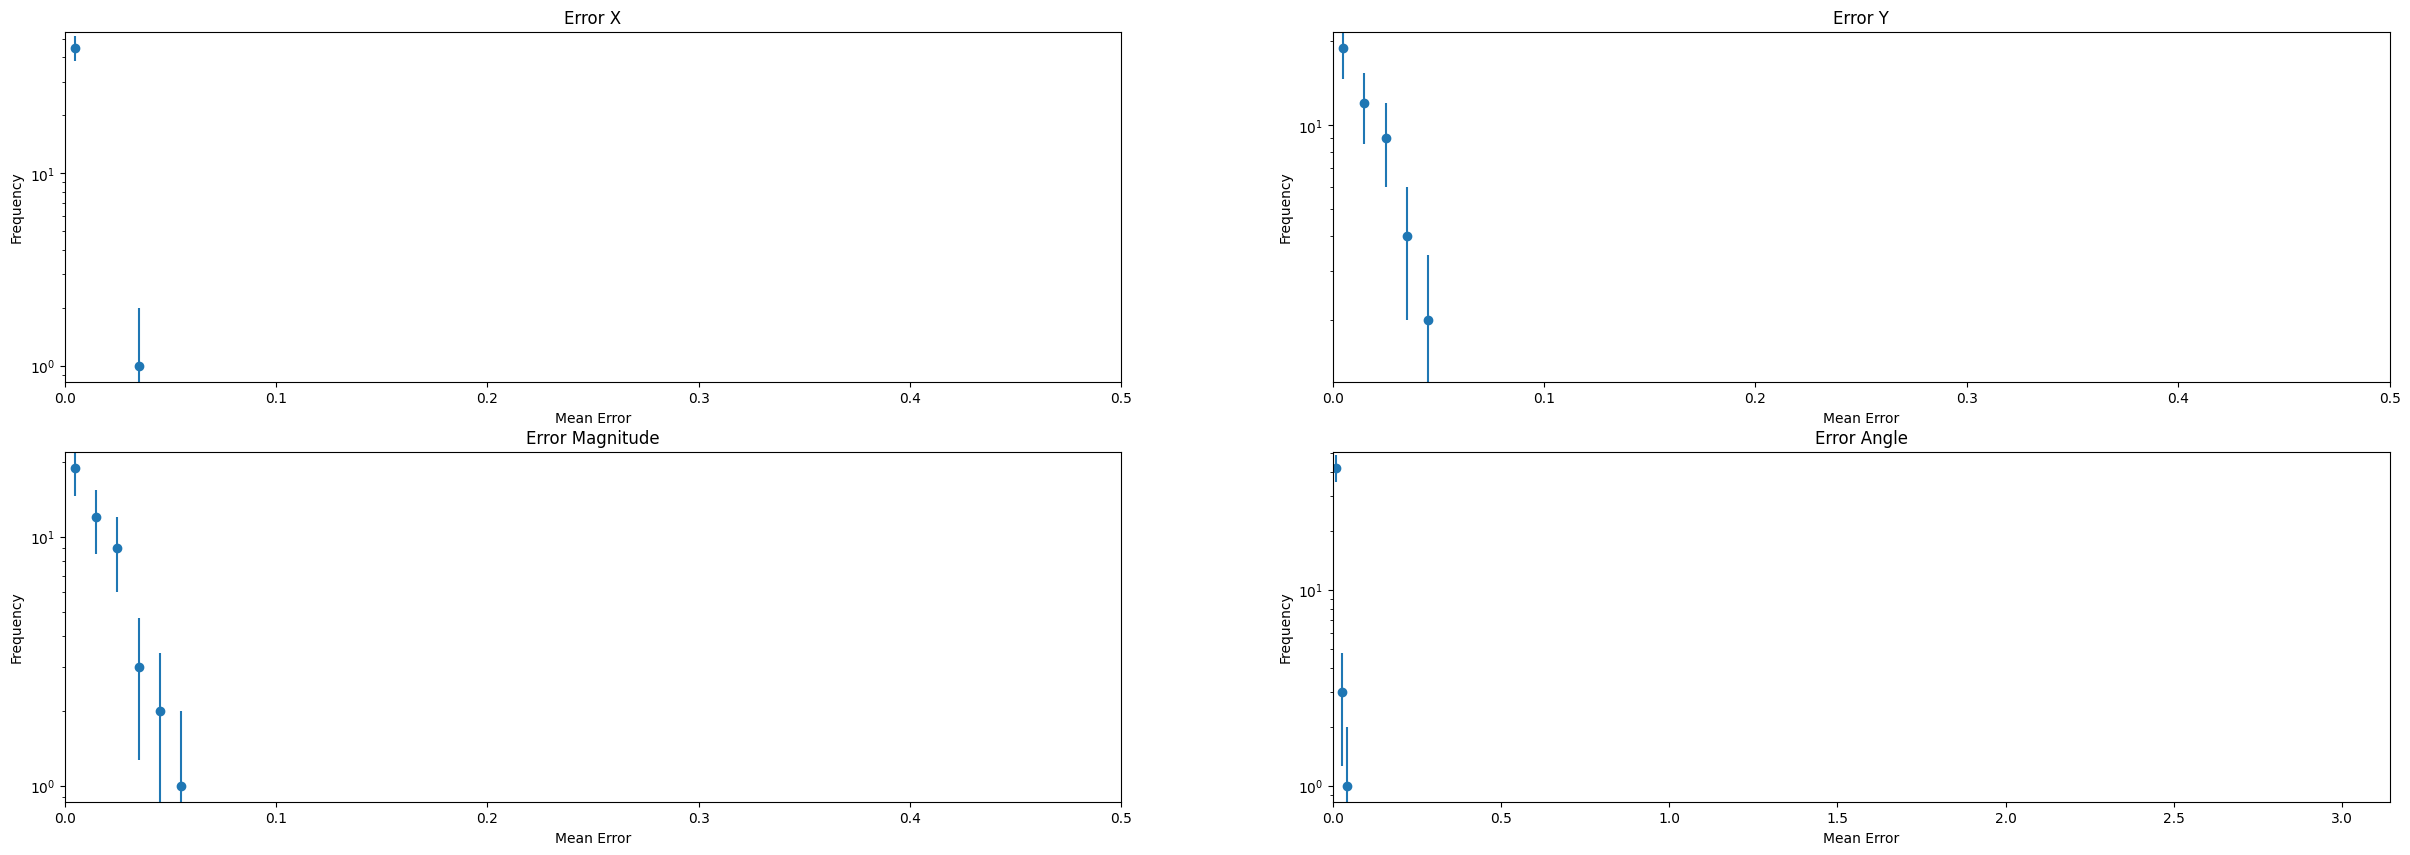

mean  error x: 0.0025309252
mean  error y: 0.016003756
mean  error magnitude: 0.01624593
mean  error angle: 0.0054327697
-------------------------
yoke


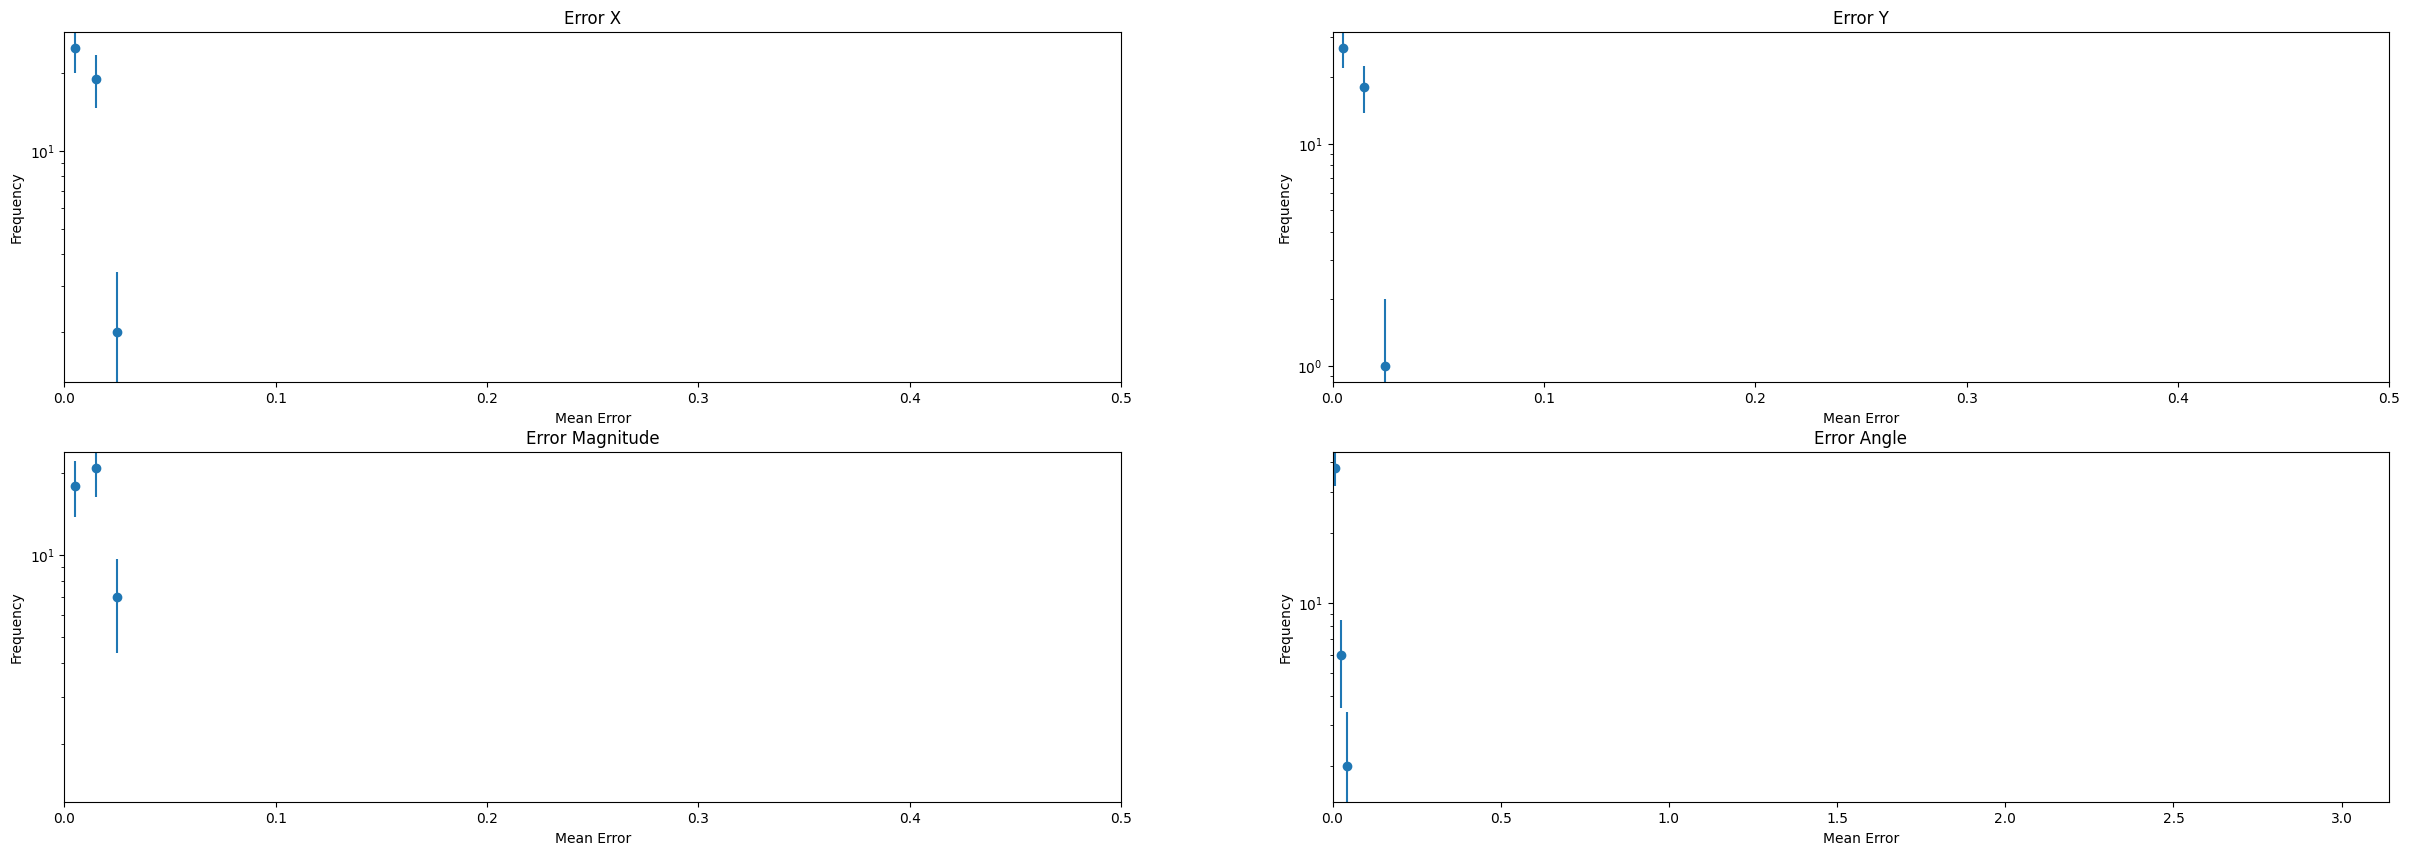

mean  error x: 0.009848142
mean  error y: 0.0099708075
mean  error magnitude: 0.012700156
mean  error angle: 0.014073352
-------------------------
coil


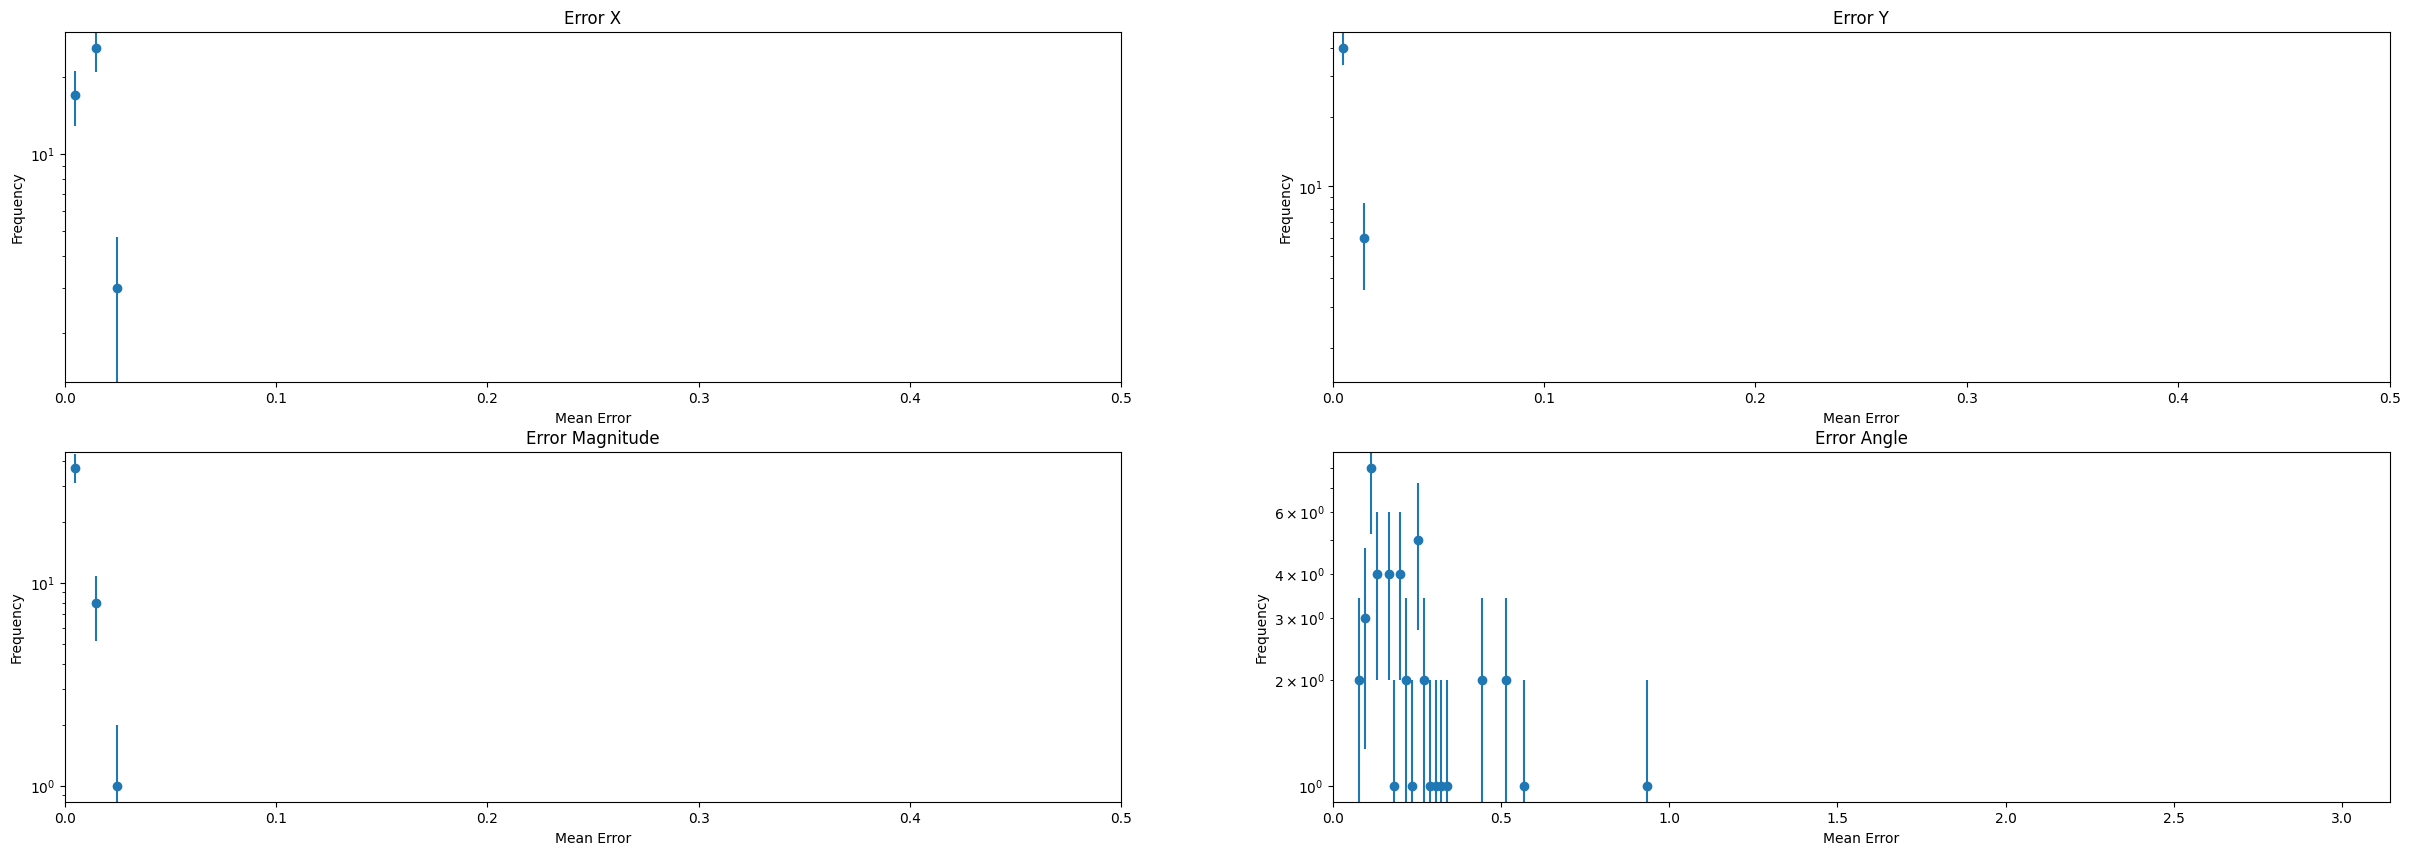

mean  error x: 0.012082872
mean  error y: 0.0063321125
mean  error magnitude: 0.00819581
mean  error angle: 0.23213996
-------------------------
rest


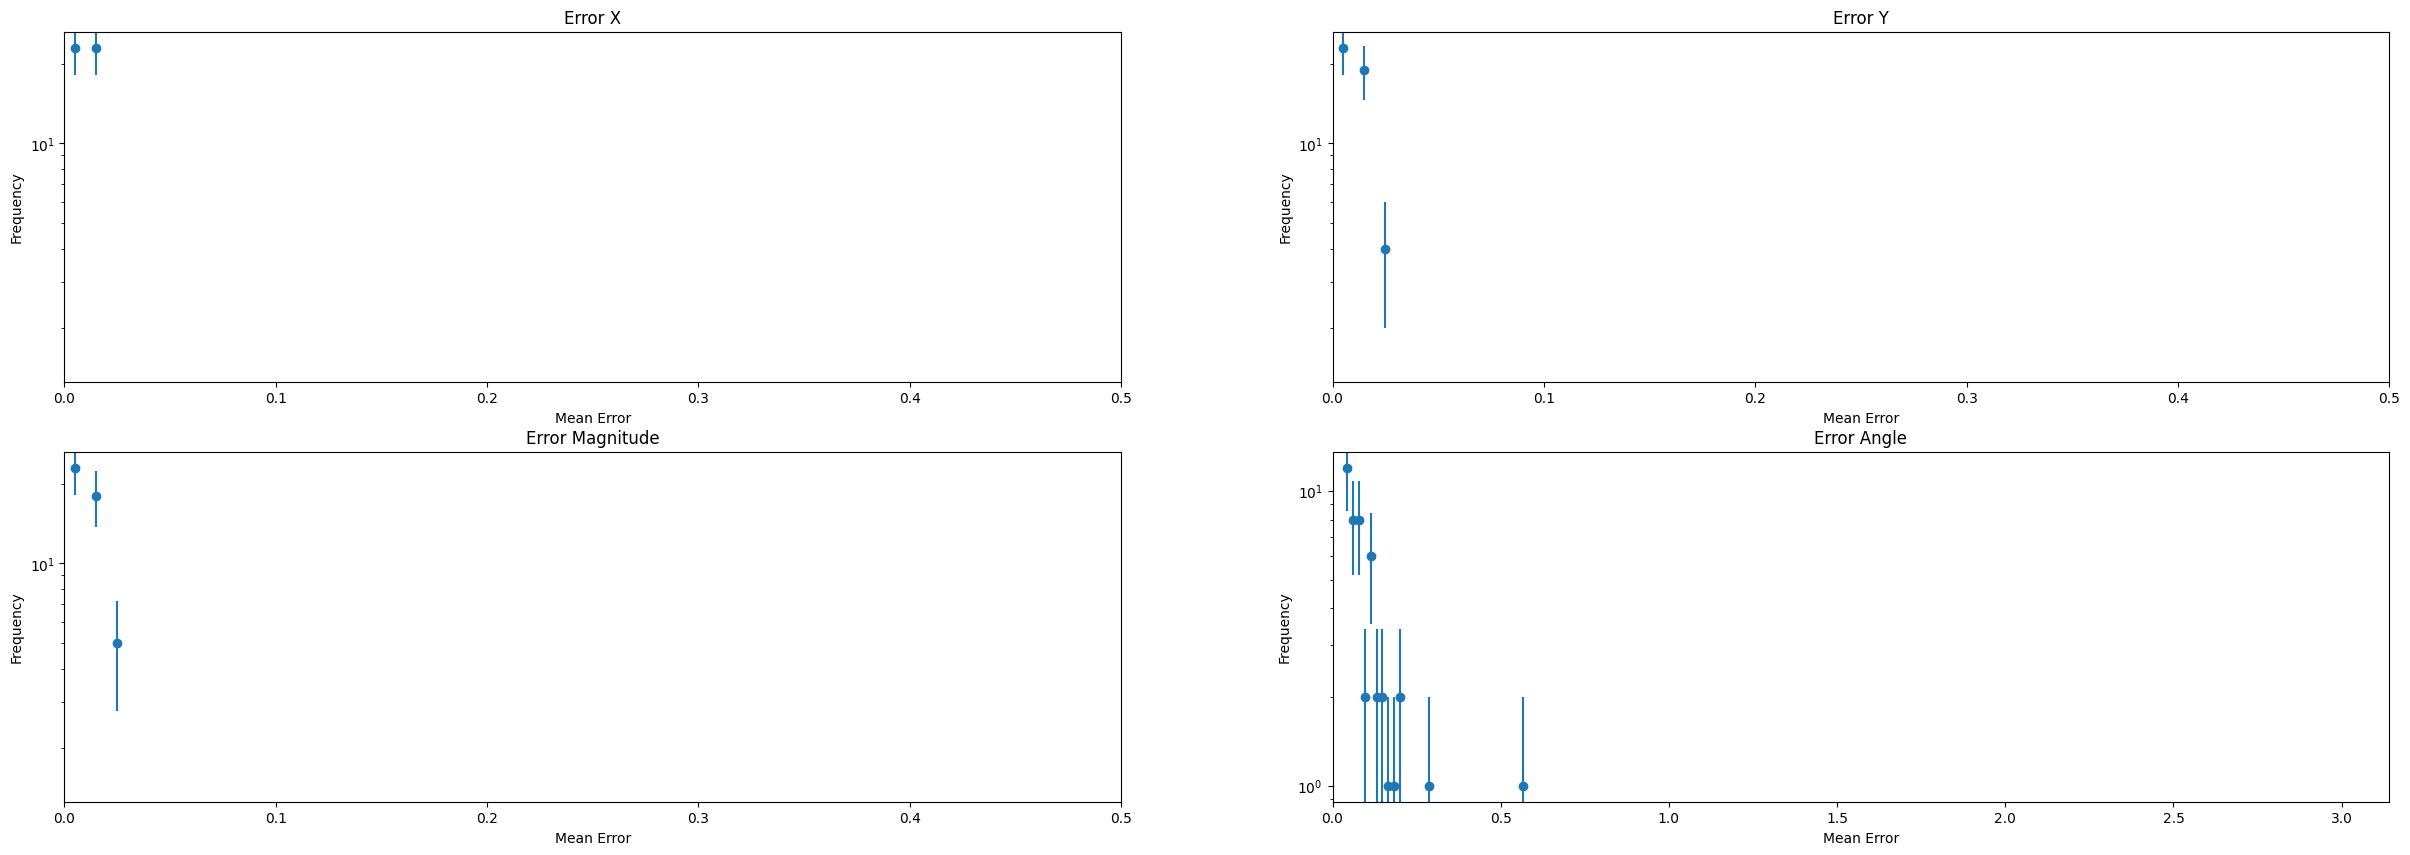

mean  error x: 0.010683365
mean  error y: 0.011129459
mean  error magnitude: 0.011502785
mean  error angle: 0.10029393


In [10]:
# mean
getErrorHistograms(model, test_loader, figureOfMerit="all")
getErrorHistograms(model, test_loader, figureOfMerit="aperture")
getErrorHistograms(model, test_loader, figureOfMerit="yoke")
getErrorHistograms(model, test_loader, figureOfMerit="coil")
getErrorHistograms(model, test_loader, figureOfMerit="rest")

-------------------------
all


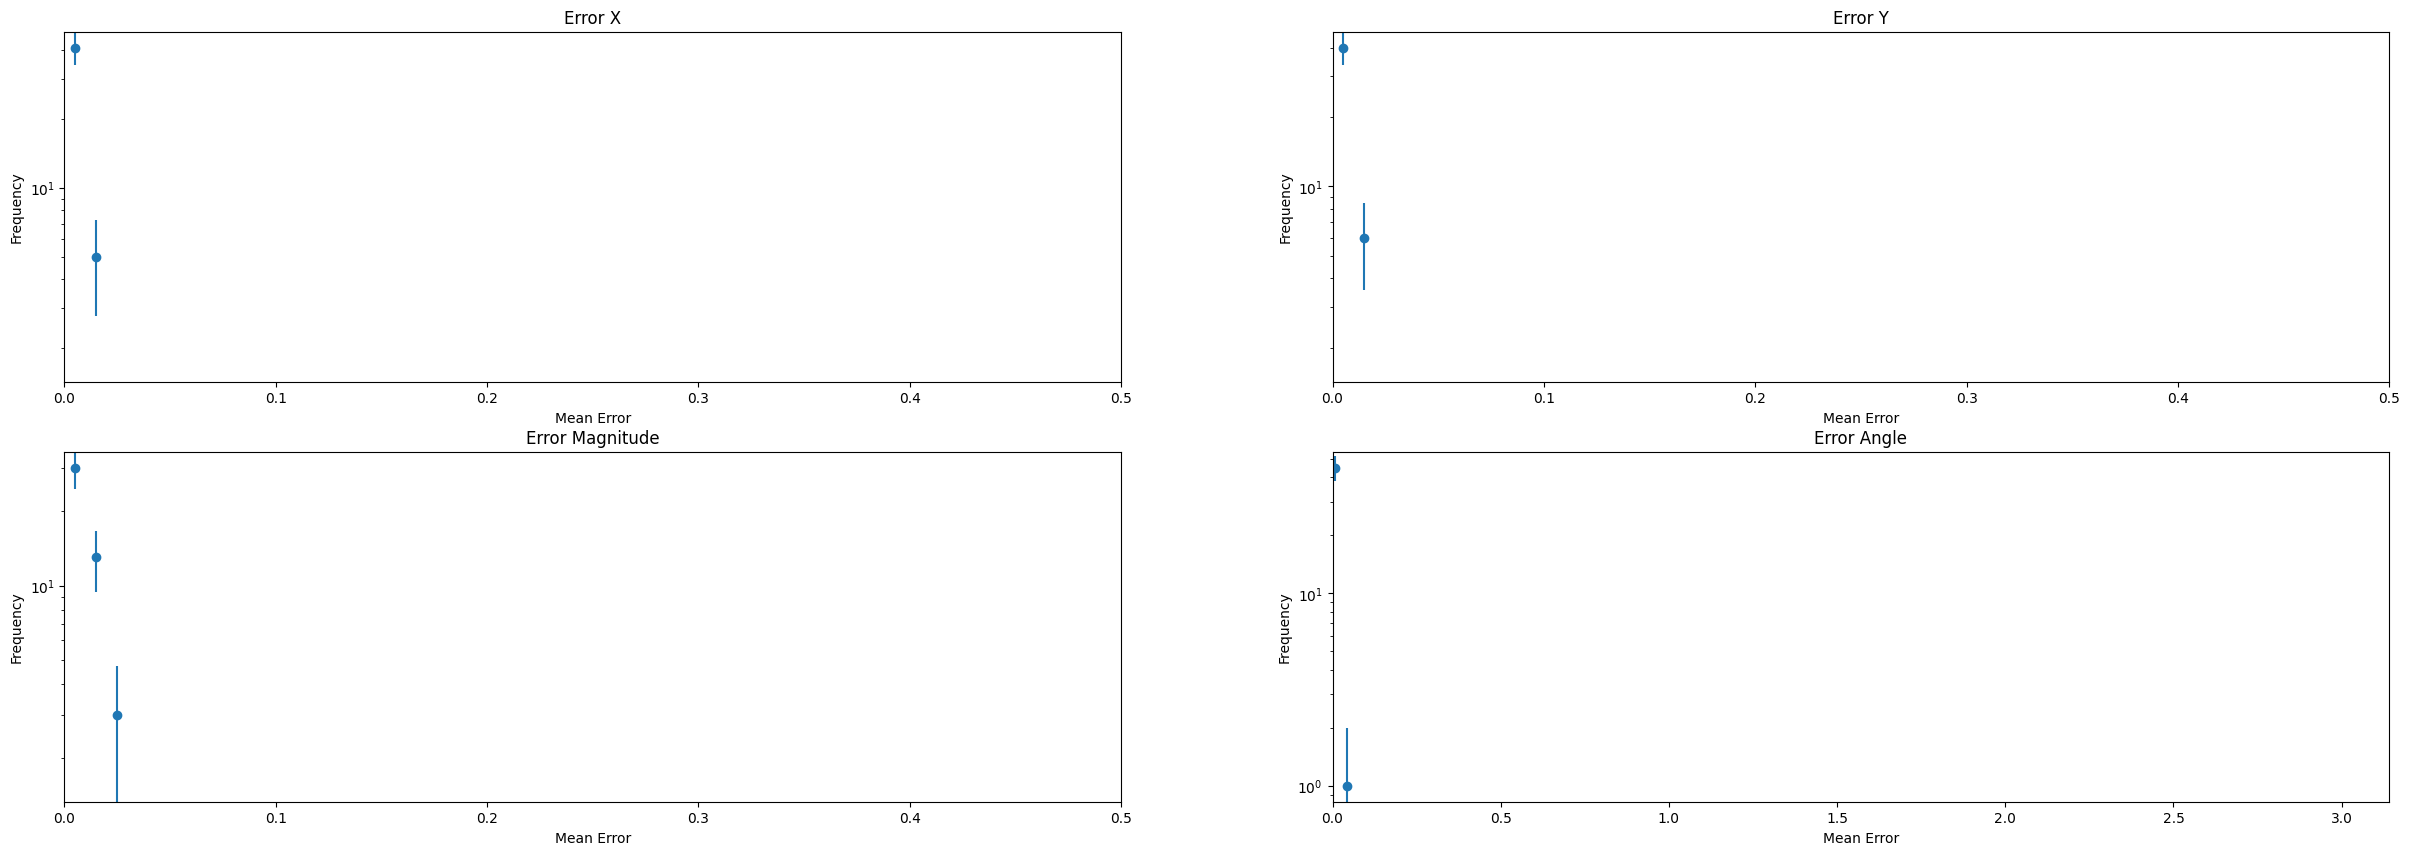

median  error x: 0.006554108
median  error y: 0.00663104
median  error magnitude: 0.009312041
median  error angle: 0.009308066
-------------------------
aperture


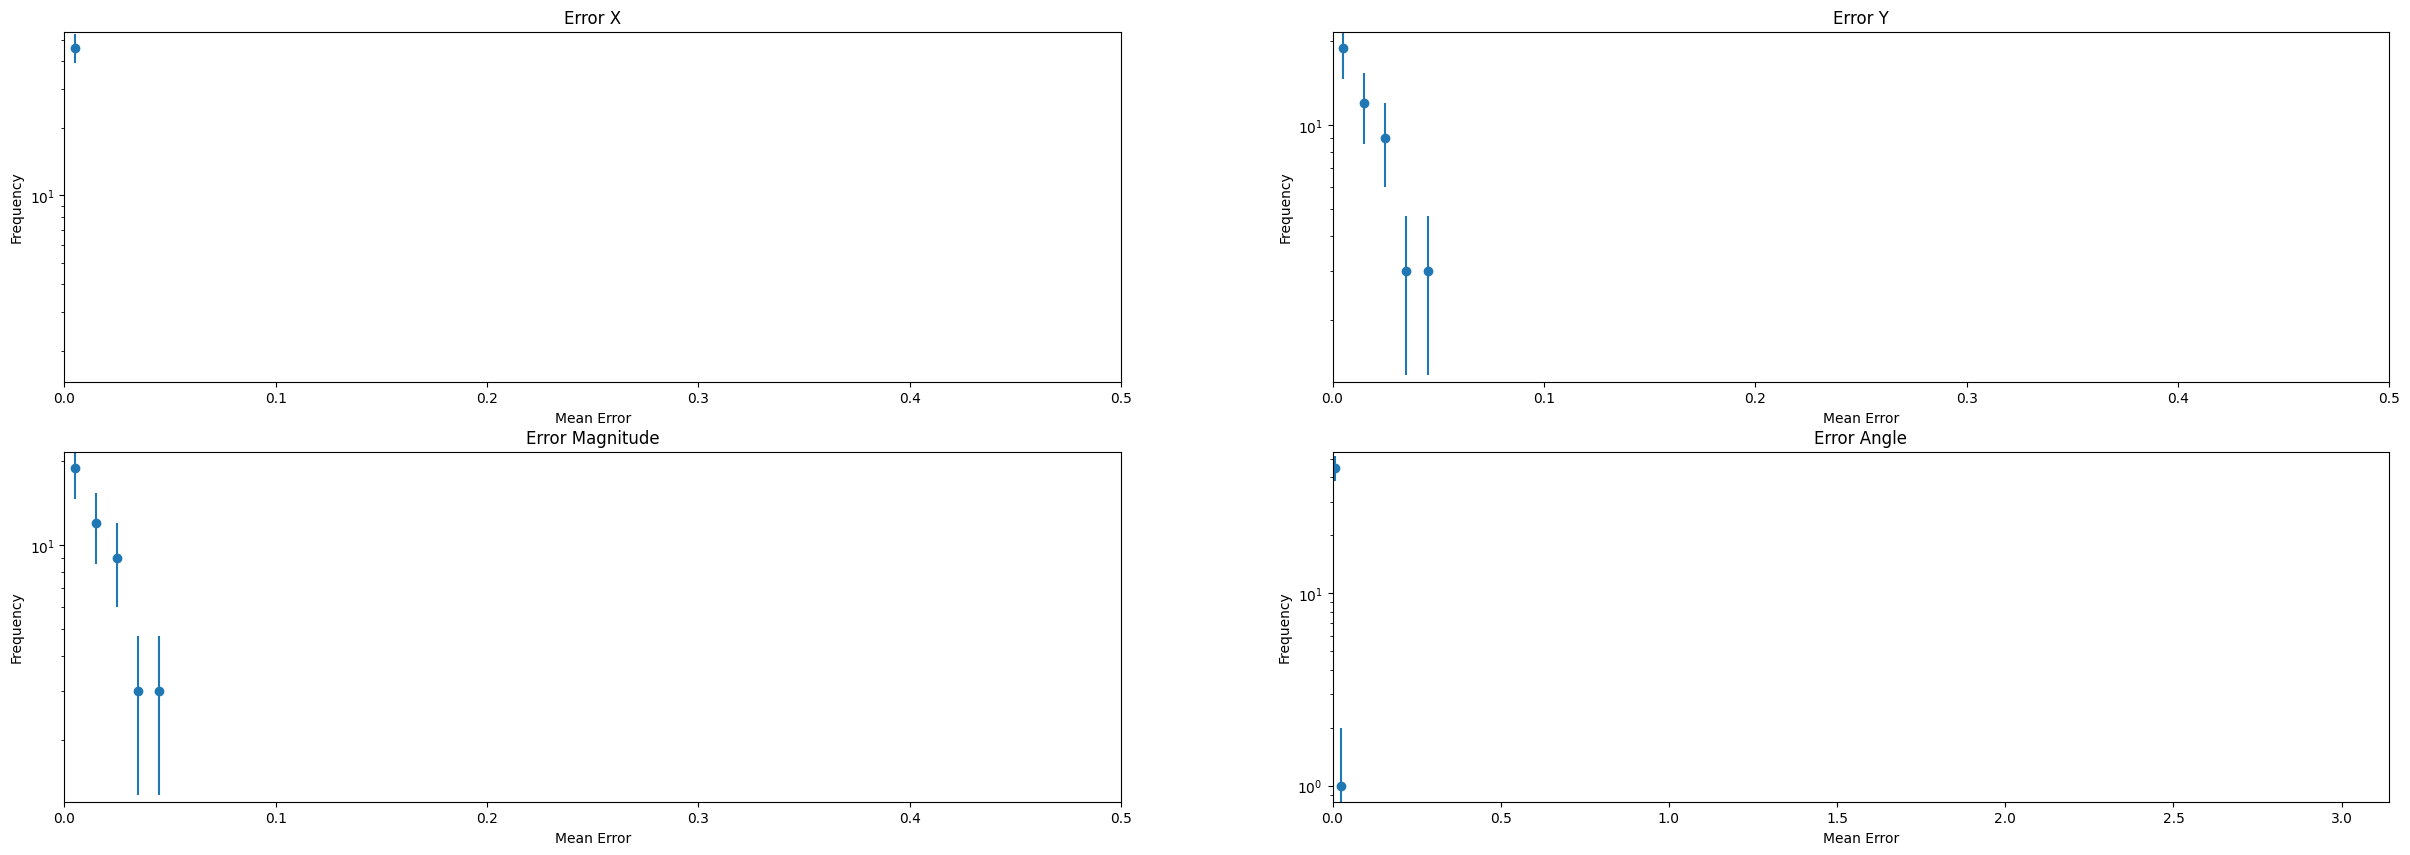

median  error x: 0.0012097041
median  error y: 0.015665762
median  error magnitude: 0.01585924
median  error angle: 0.0029108084
-------------------------
yoke


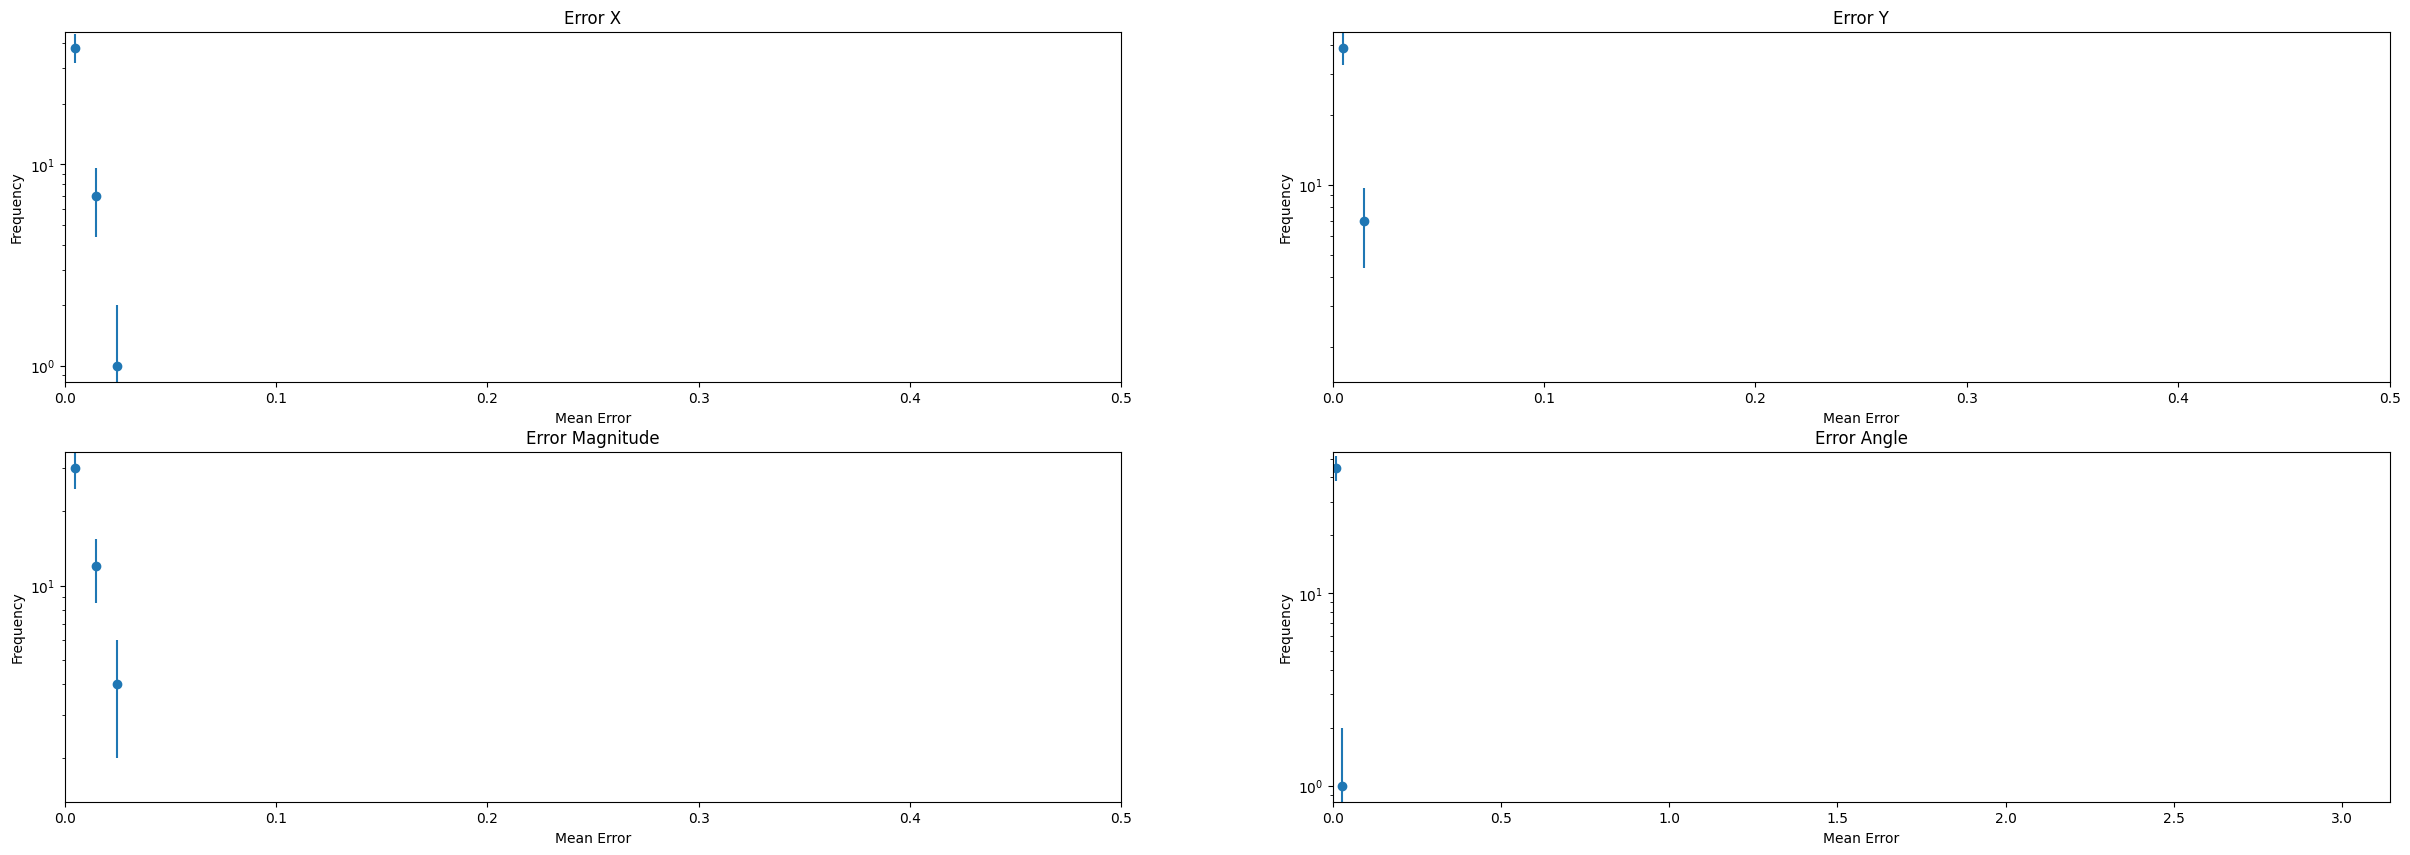

median  error x: 0.007263182
median  error y: 0.0066822637
median  error magnitude: 0.009897729
median  error angle: 0.008844002
-------------------------
coil


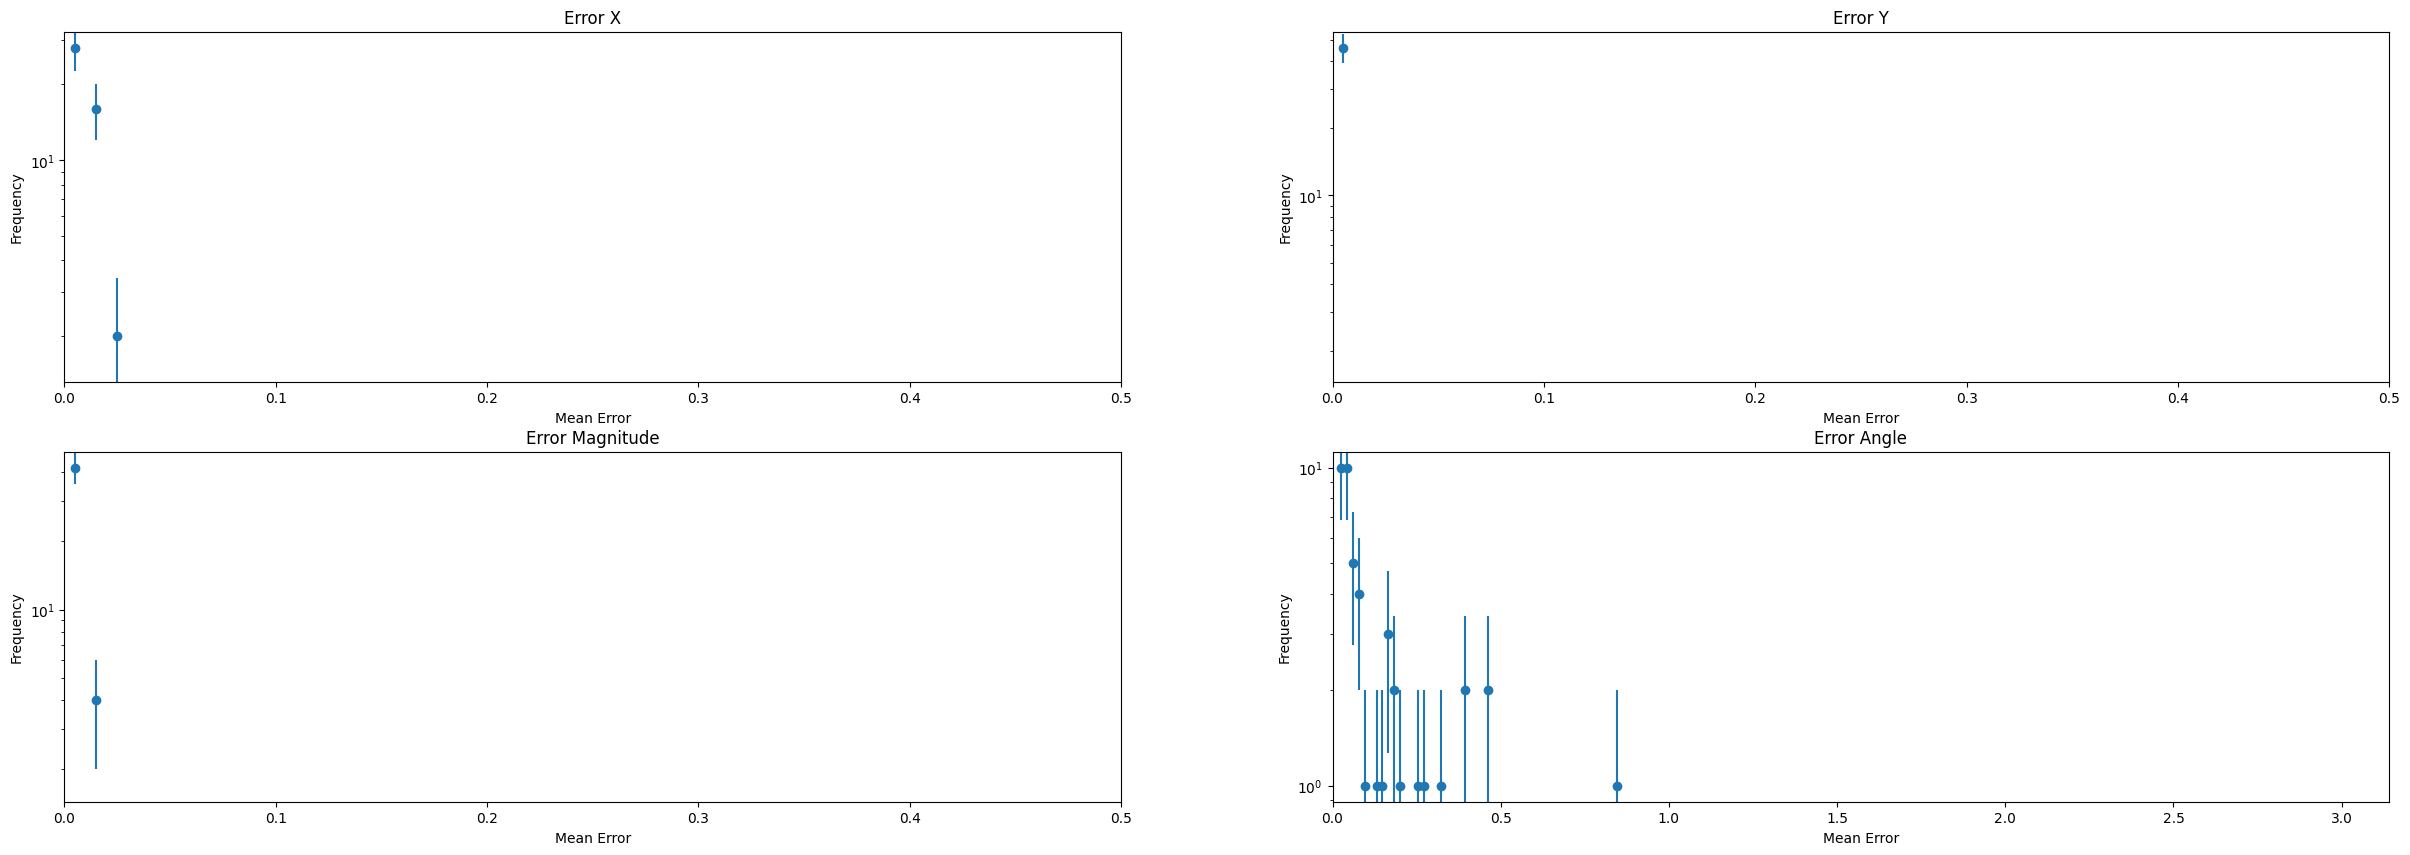

median  error x: 0.009793815
median  error y: 0.004350544
median  error magnitude: 0.006132556
median  error angle: 0.13358985
-------------------------
rest


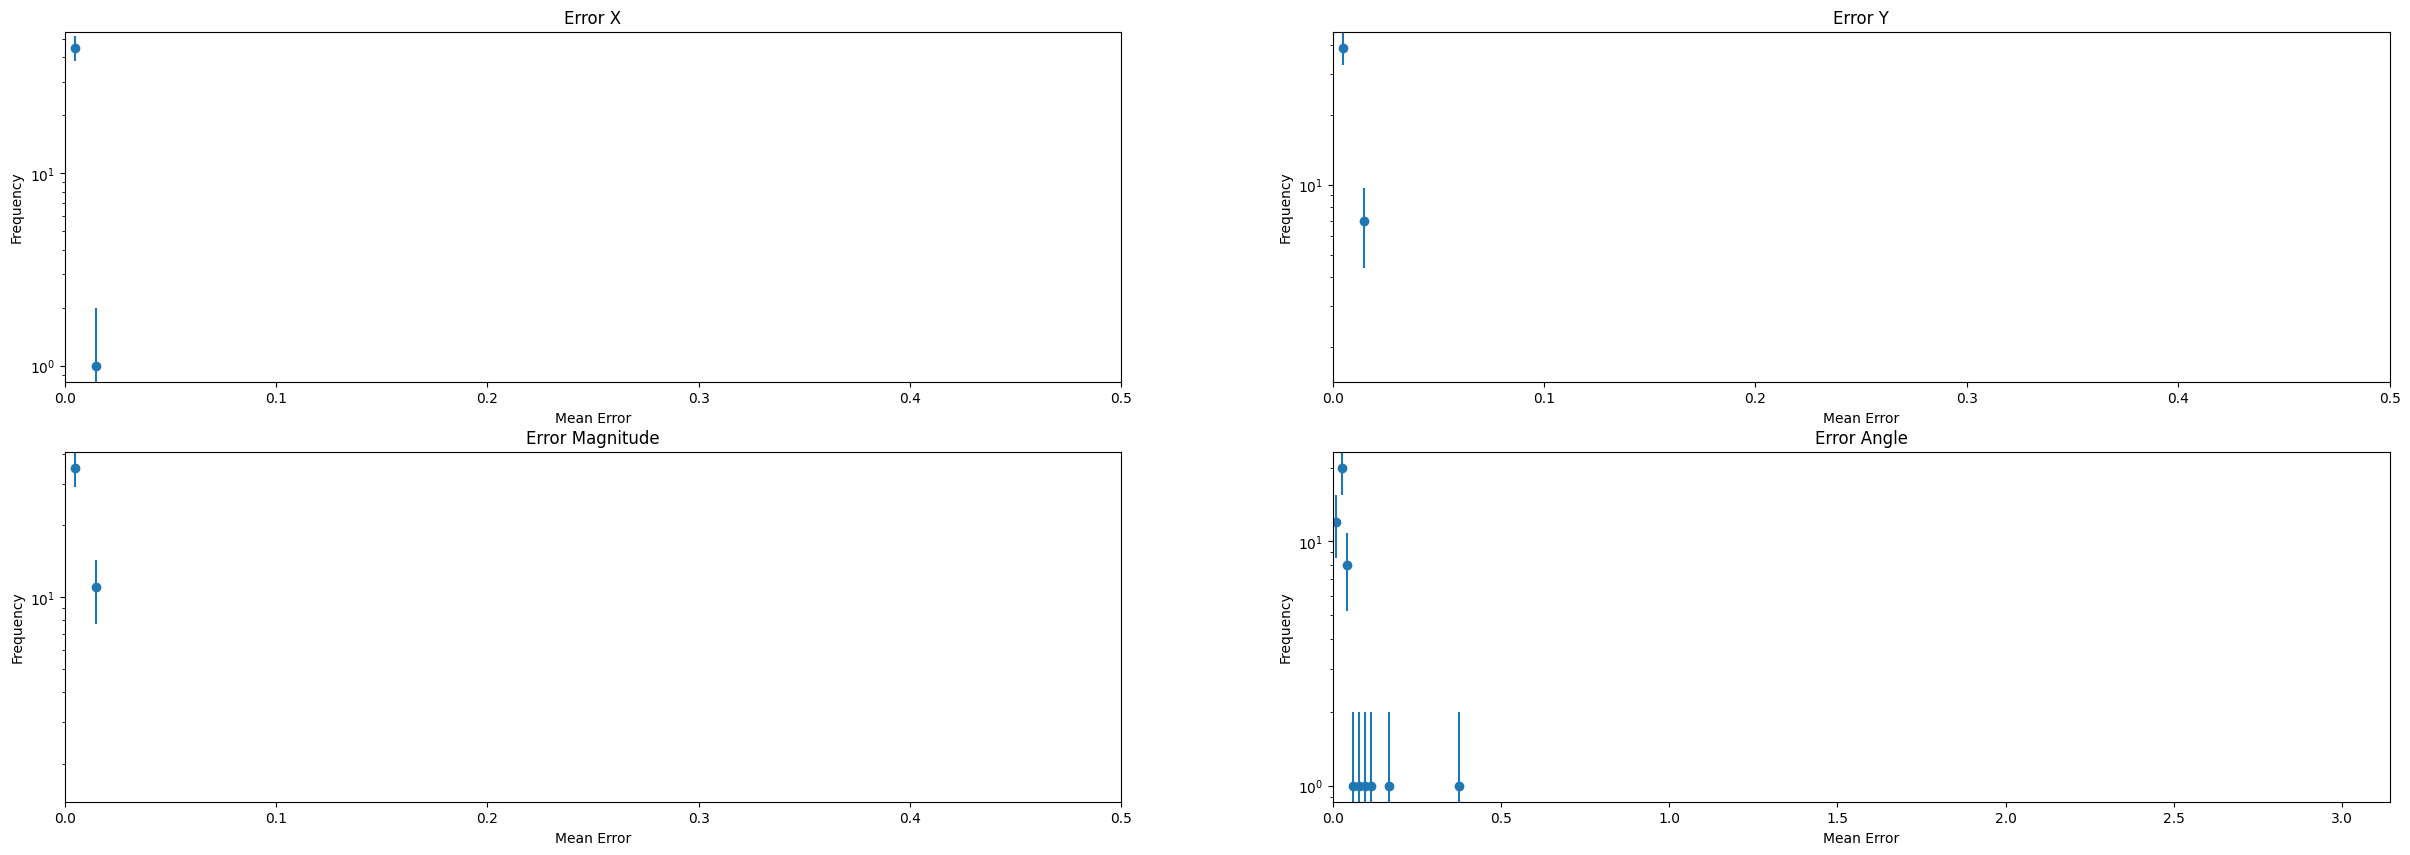

median  error x: 0.006612803
median  error y: 0.0067335516
median  error magnitude: 0.0074071535
median  error angle: 0.040444992


In [11]:
# median
getErrorHistograms(model, test_loader, figureOfMerit="all", metric="median")
getErrorHistograms(model, test_loader, figureOfMerit="aperture", metric="median")
getErrorHistograms(model, test_loader, figureOfMerit="yoke", metric="median")
getErrorHistograms(model, test_loader, figureOfMerit="coil", metric="median")
getErrorHistograms(model, test_loader, figureOfMerit="rest", metric="median")

-------------------------
all


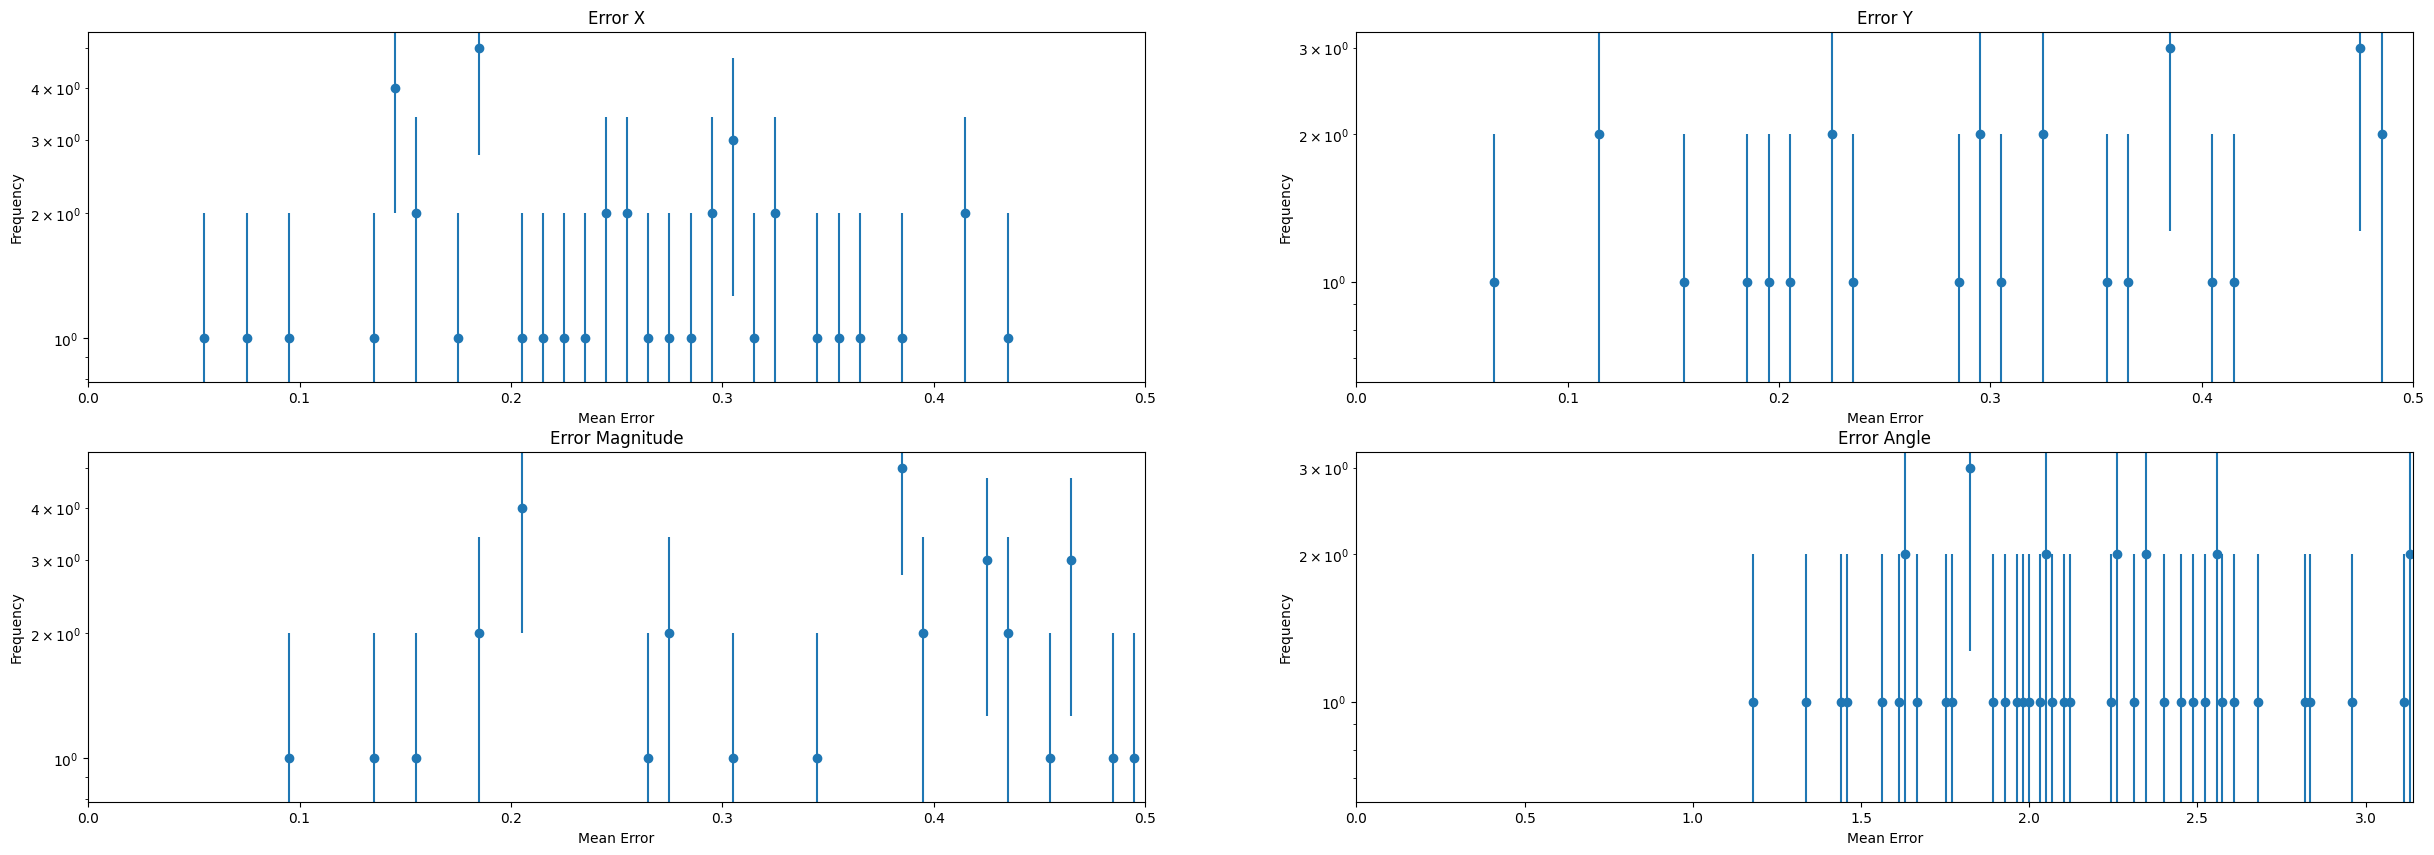

max  error x: 0.29751208
max  error y: 0.46167552
max  error magnitude: 0.47373688
max  error angle: 2.1608446
-------------------------
aperture


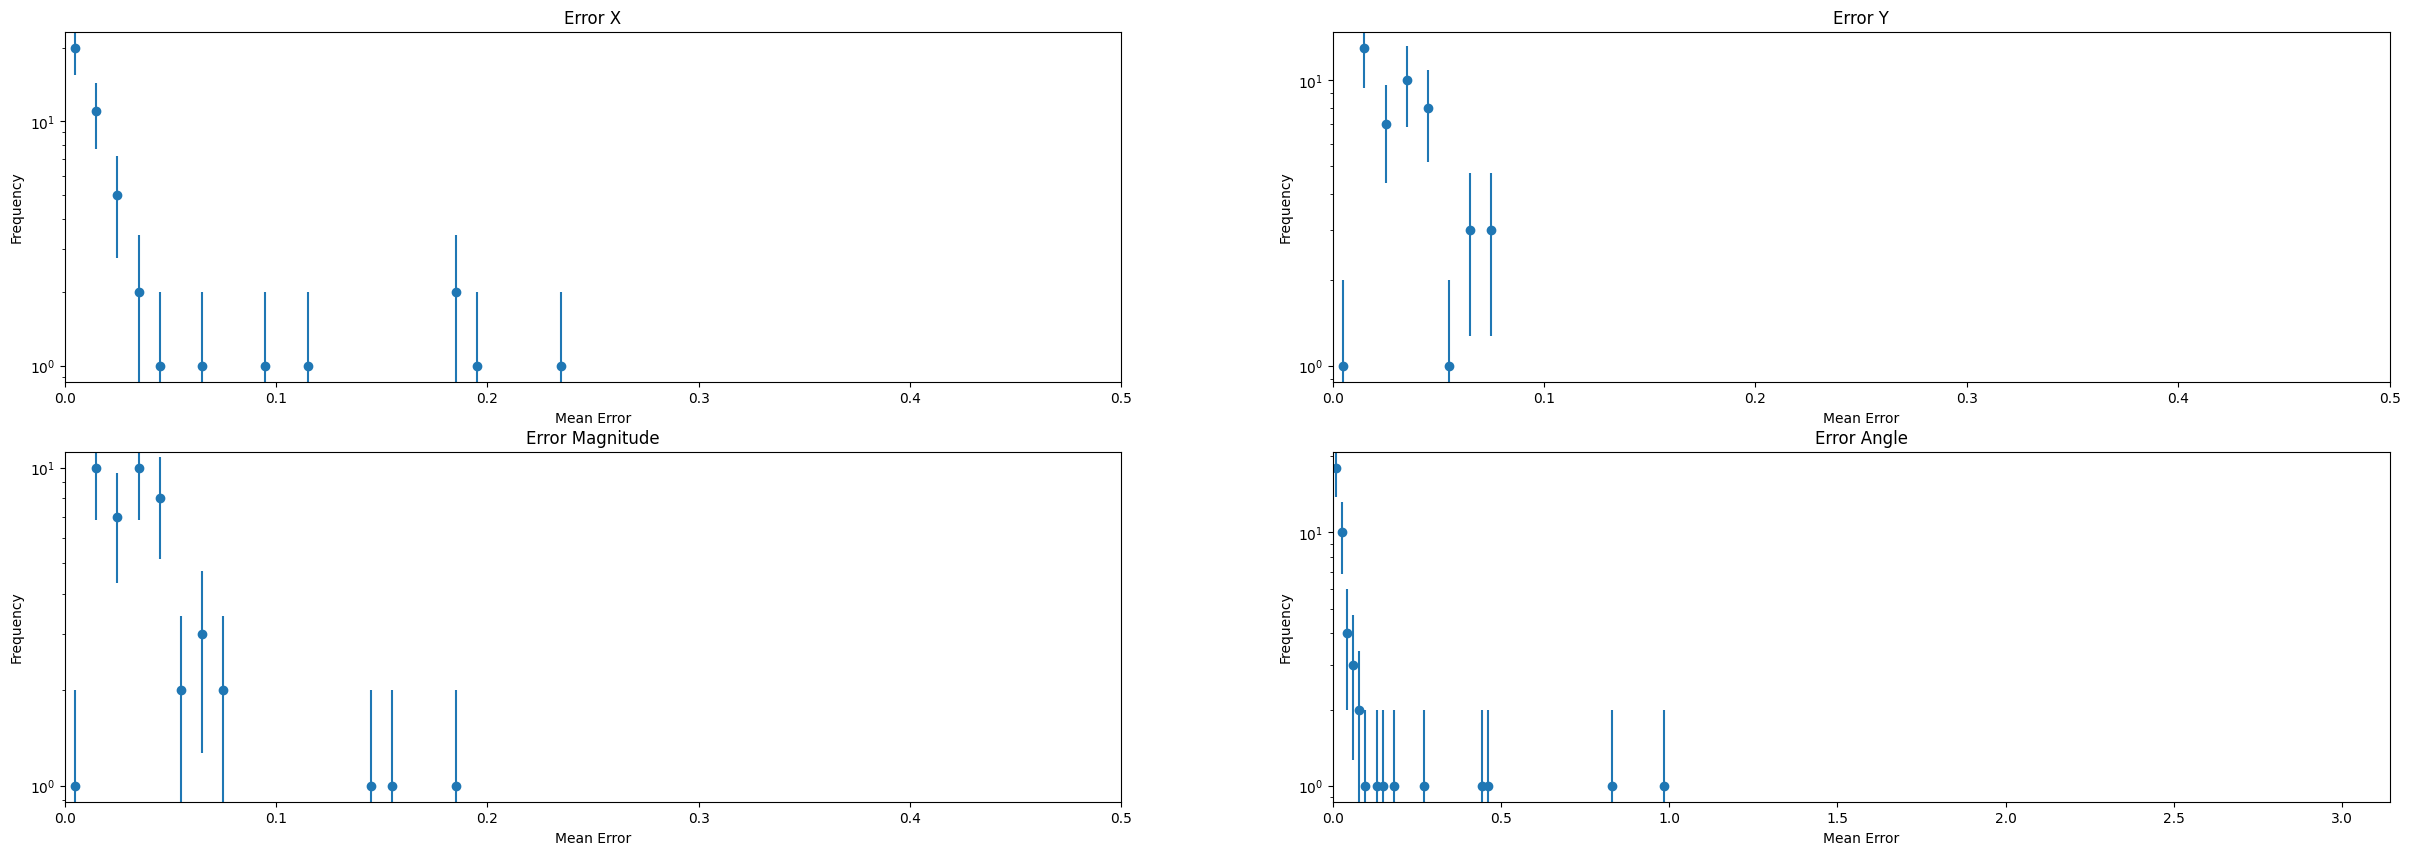

max  error x: 0.034634415
max  error y: 0.033059627
max  error magnitude: 0.042441066
max  error angle: 0.096688926
-------------------------
yoke


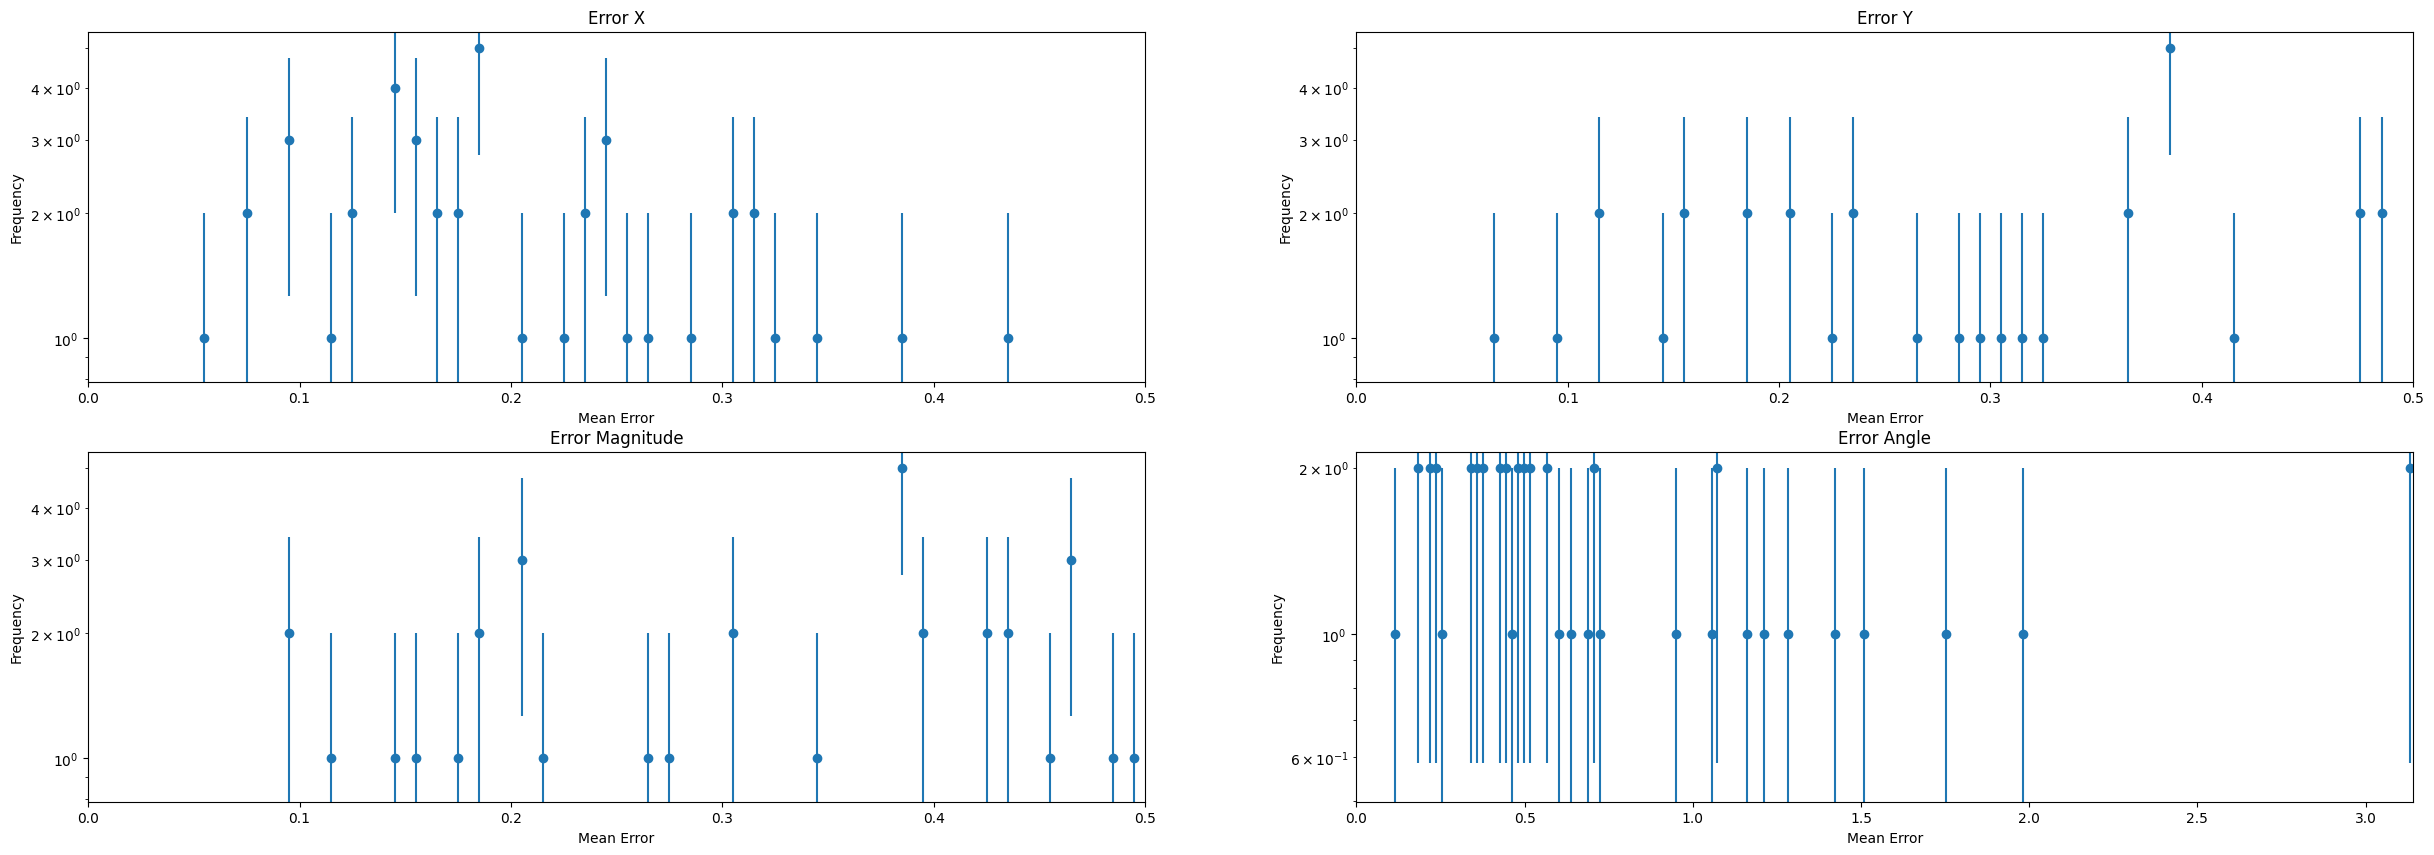

max  error x: 0.25168294
max  error y: 0.40712336
max  error magnitude: 0.4394704
max  error angle: 0.75985044
-------------------------
coil


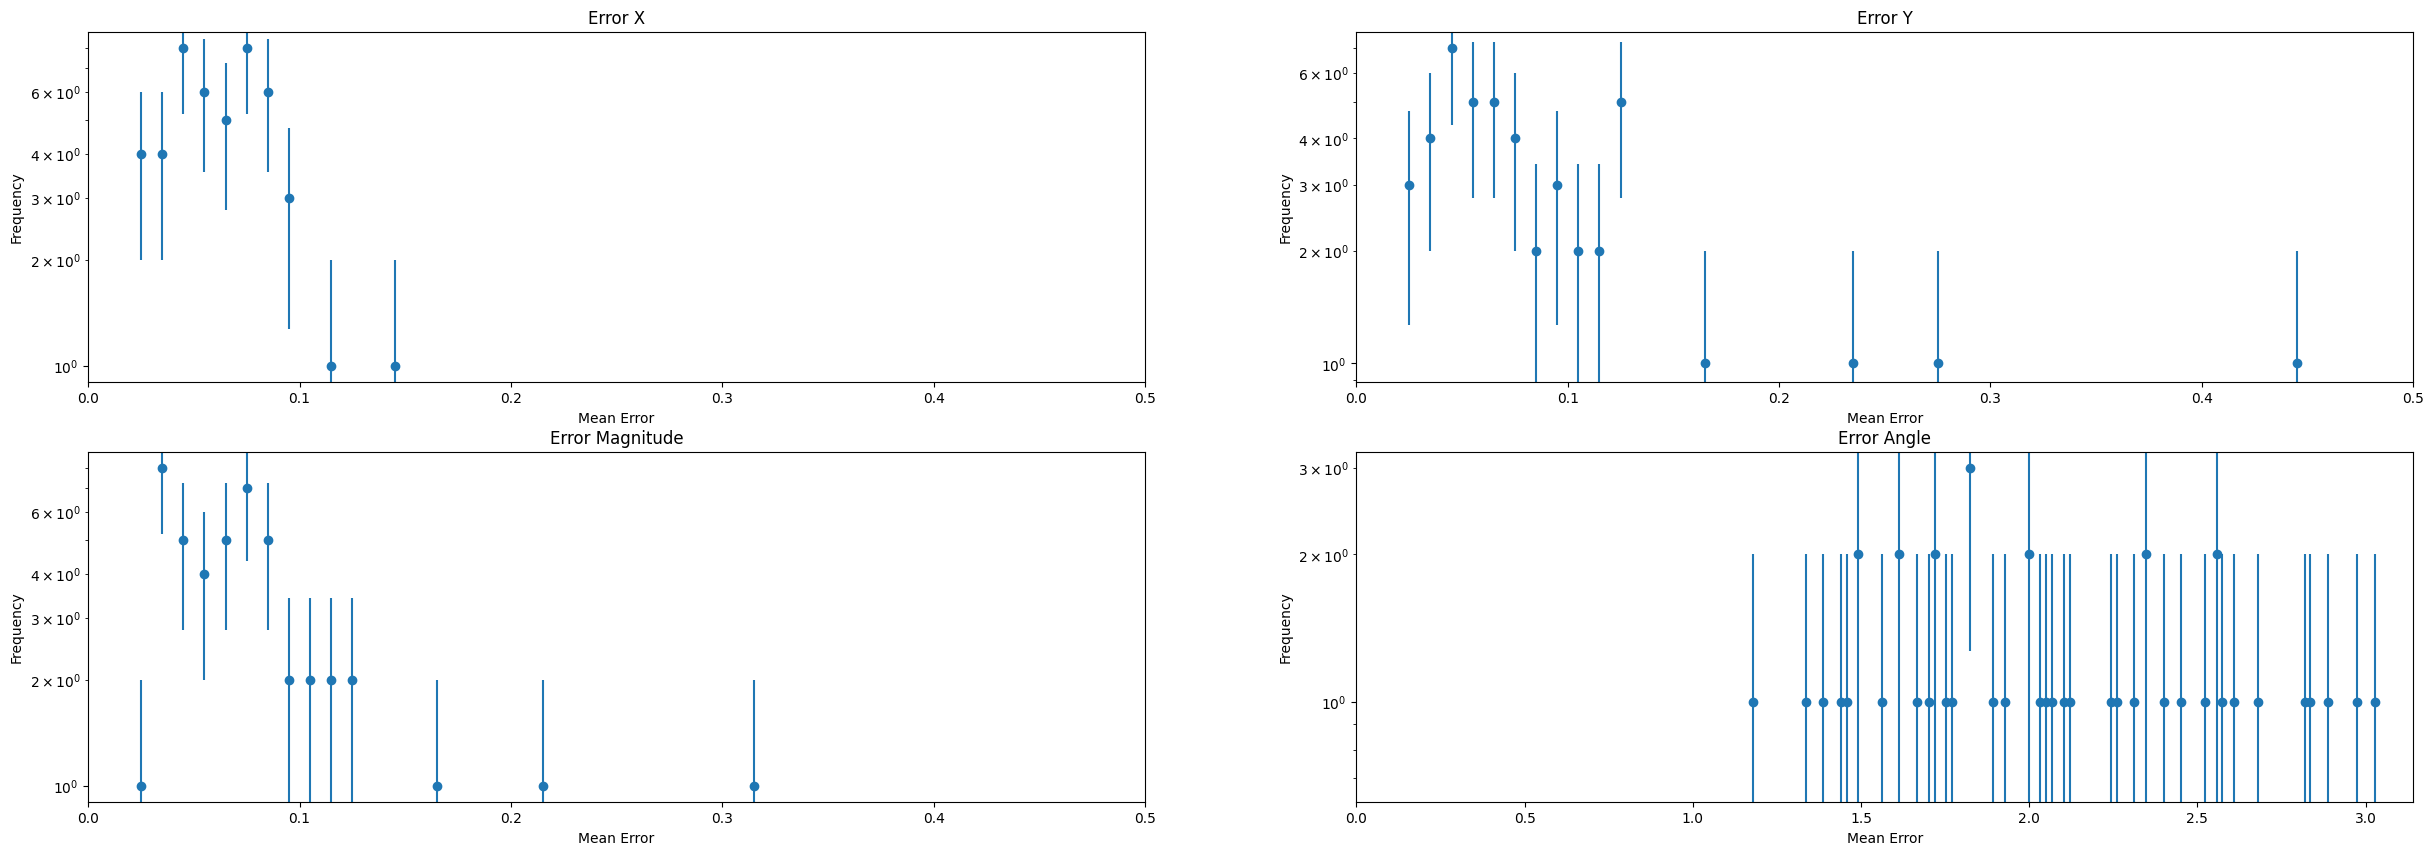

max  error x: 0.063361794
max  error y: 0.08829095
max  error magnitude: 0.07835748
max  error angle: 2.0657654
-------------------------
rest


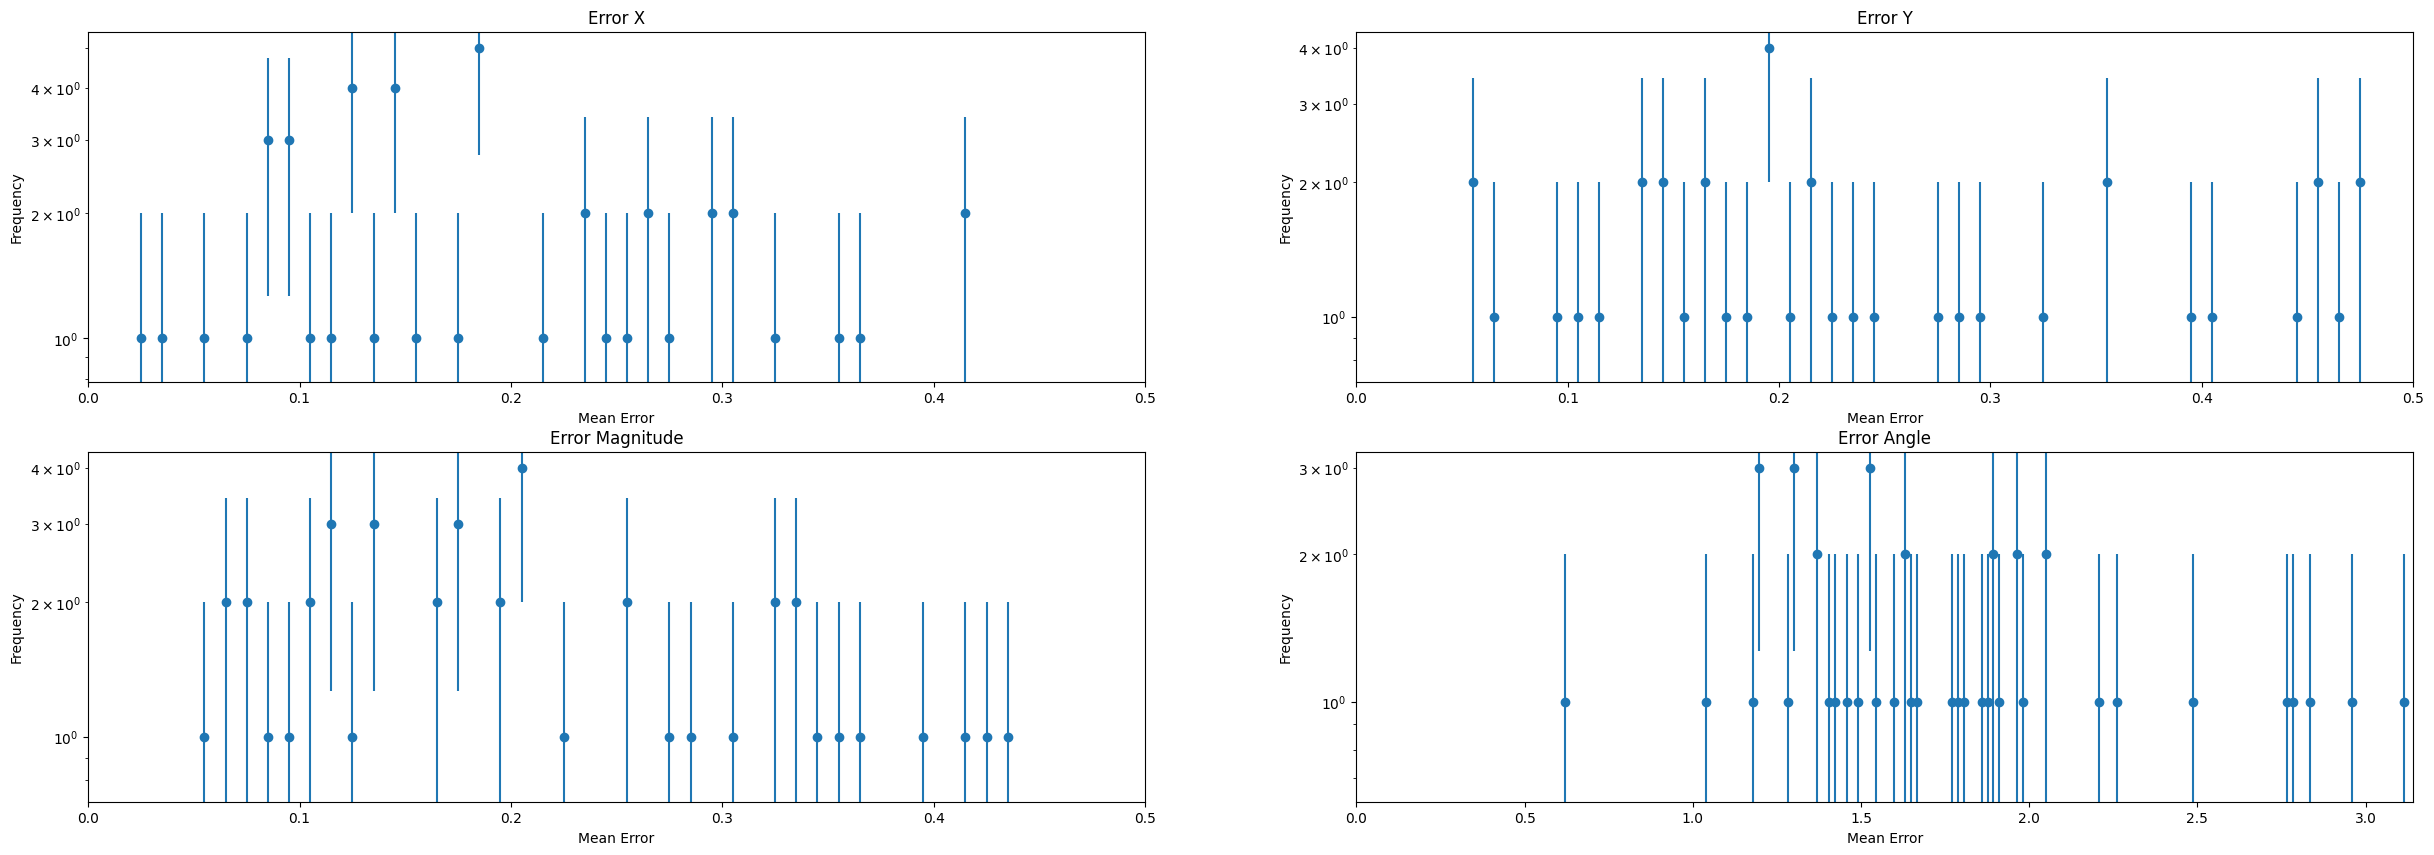

max  error x: 0.19602558
max  error y: 0.3078994
max  error magnitude: 0.23741135
max  error angle: 1.7529463


In [12]:
# max
getErrorHistograms(model, test_loader, figureOfMerit="all", metric="max")
getErrorHistograms(model, test_loader, figureOfMerit="aperture", metric="max")
getErrorHistograms(model, test_loader, figureOfMerit="yoke", metric="max")
getErrorHistograms(model, test_loader, figureOfMerit="coil", metric="max")
getErrorHistograms(model, test_loader, figureOfMerit="rest", metric="max")

-------------------------
all


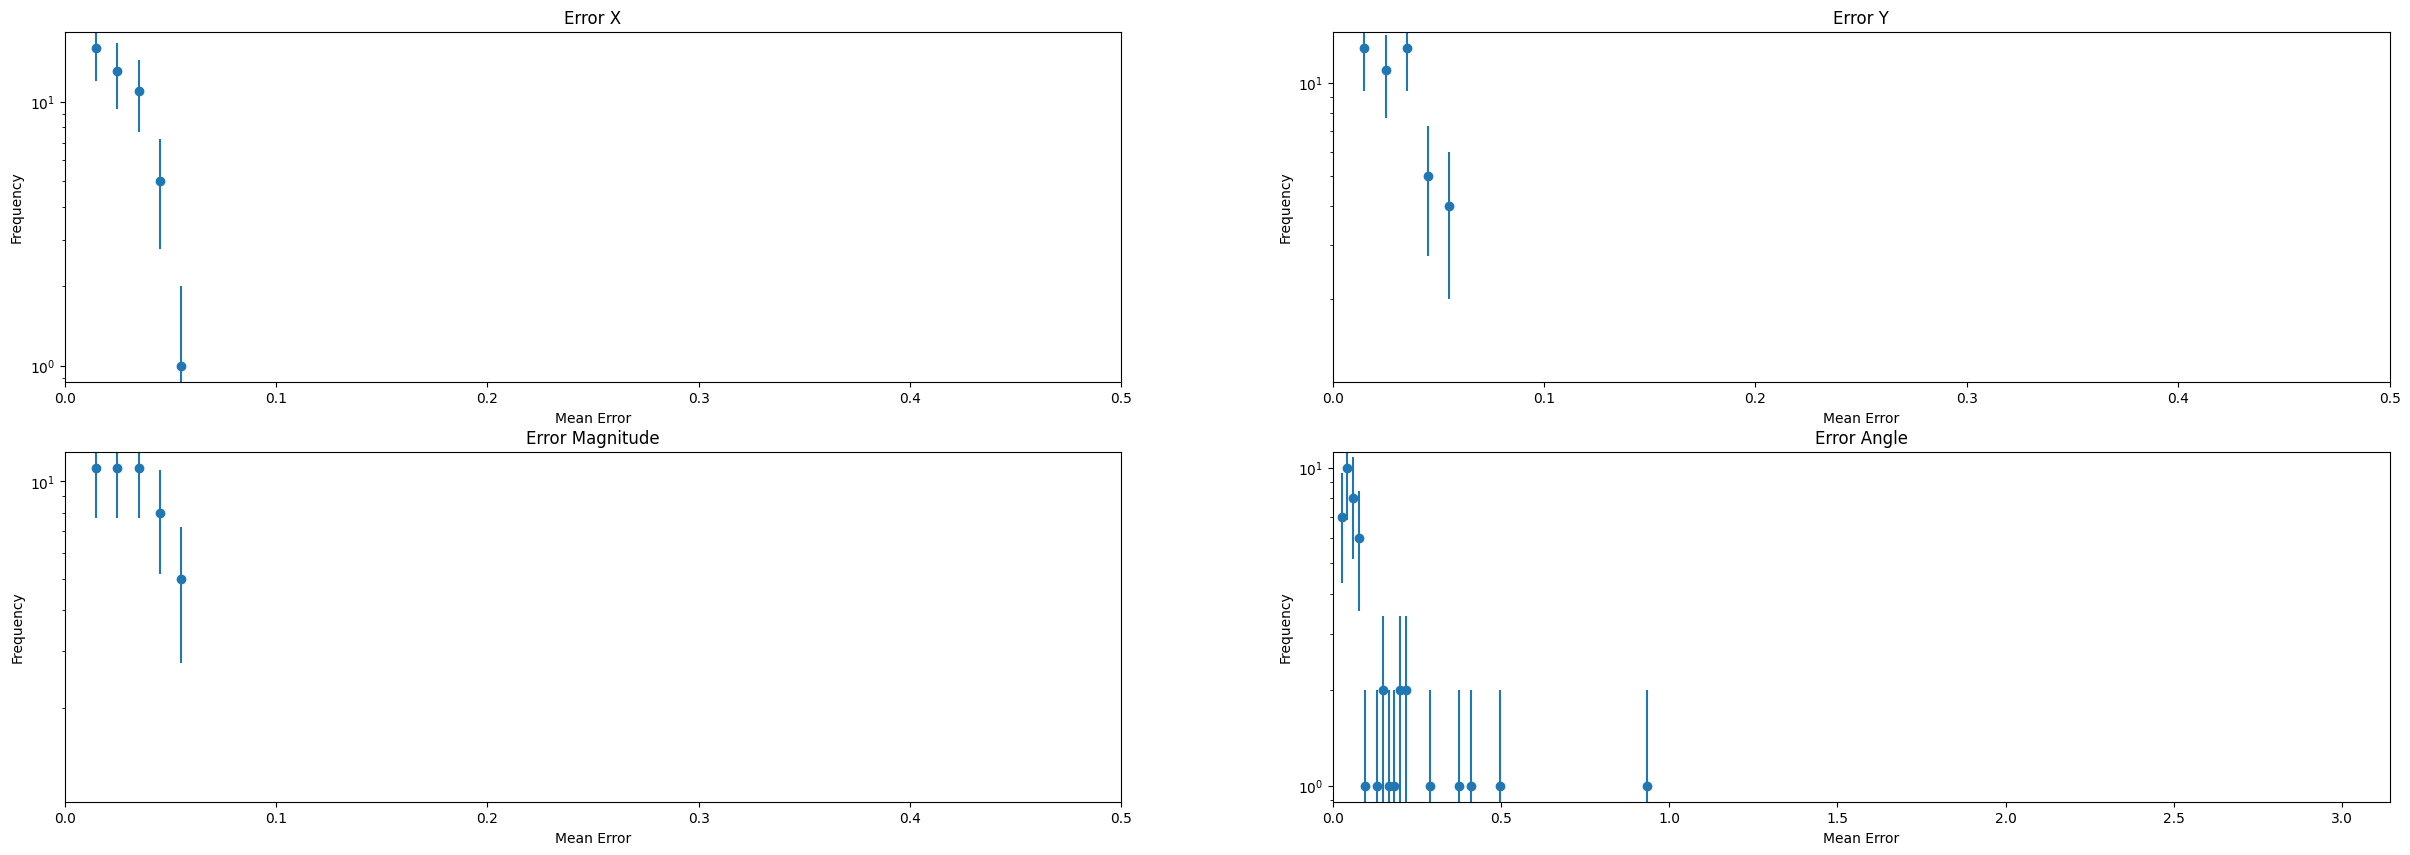

perc95  error x: 0.02623242401801373
perc95  error y: 0.02912996017738528
perc95  error magnitude: 0.03141112058706905
perc95  error angle: 0.12786568584649446
-------------------------
aperture


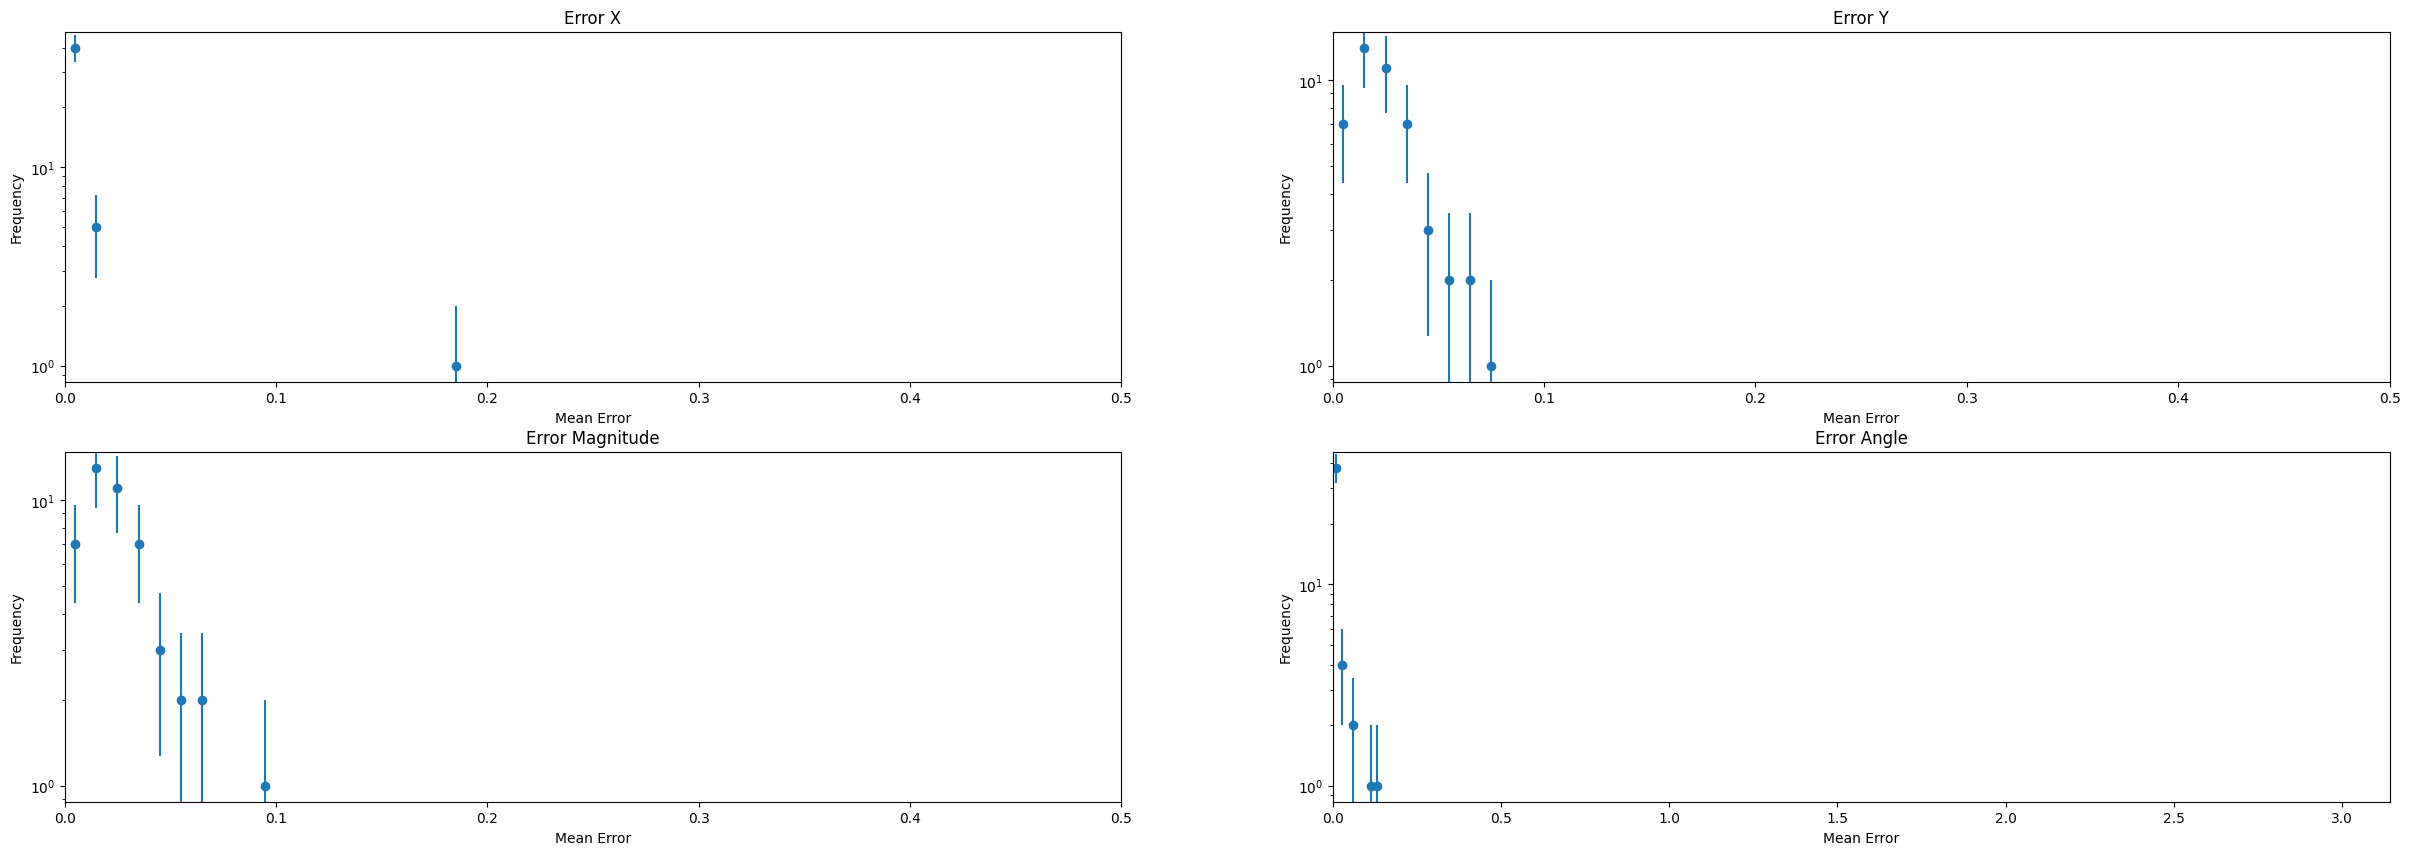

perc95  error x: 0.008850509722200828
perc95  error y: 0.025822498171549774
perc95  error magnitude: 0.02638111655073969
perc95  error angle: 0.01635776861854221
-------------------------
yoke


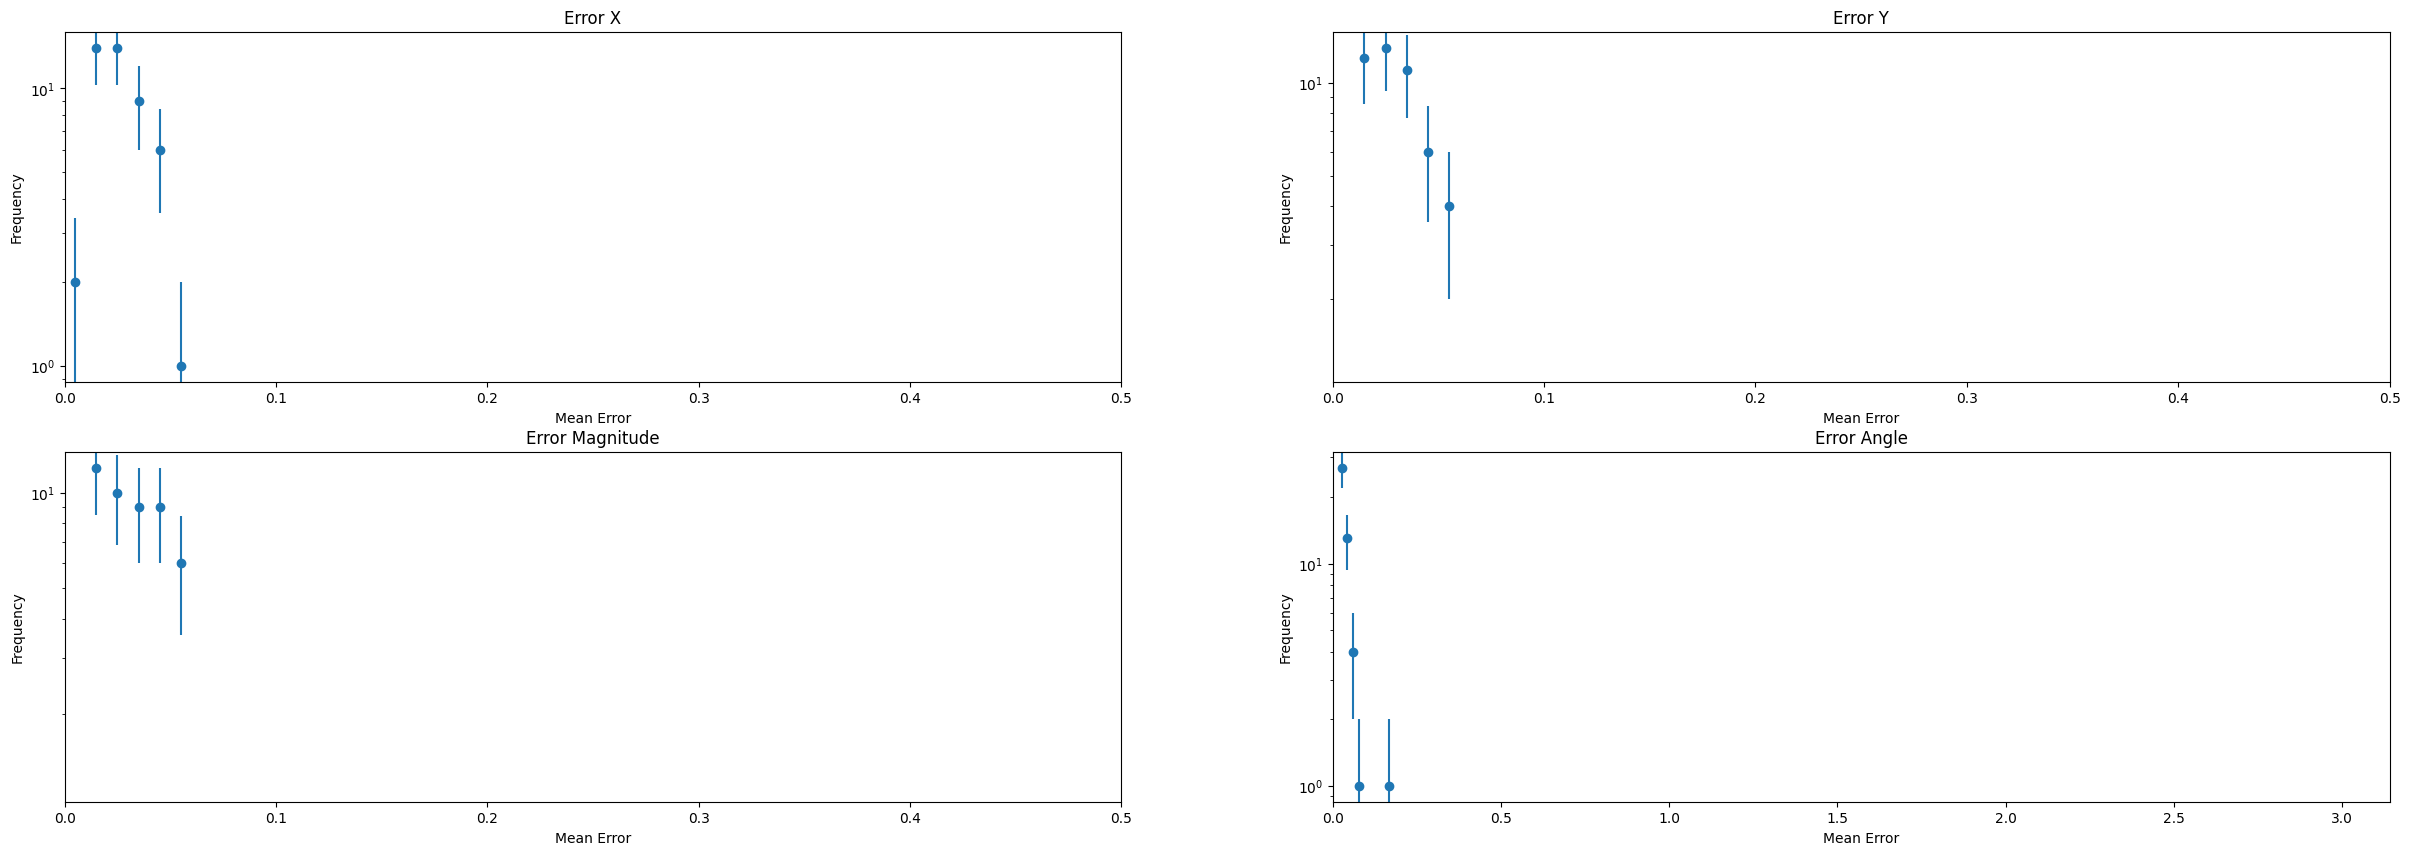

perc95  error x: 0.026111782574013833
perc95  error y: 0.029867164499085875
perc95  error magnitude: 0.03205512592002101
perc95  error angle: 0.03865692485933717
-------------------------
coil


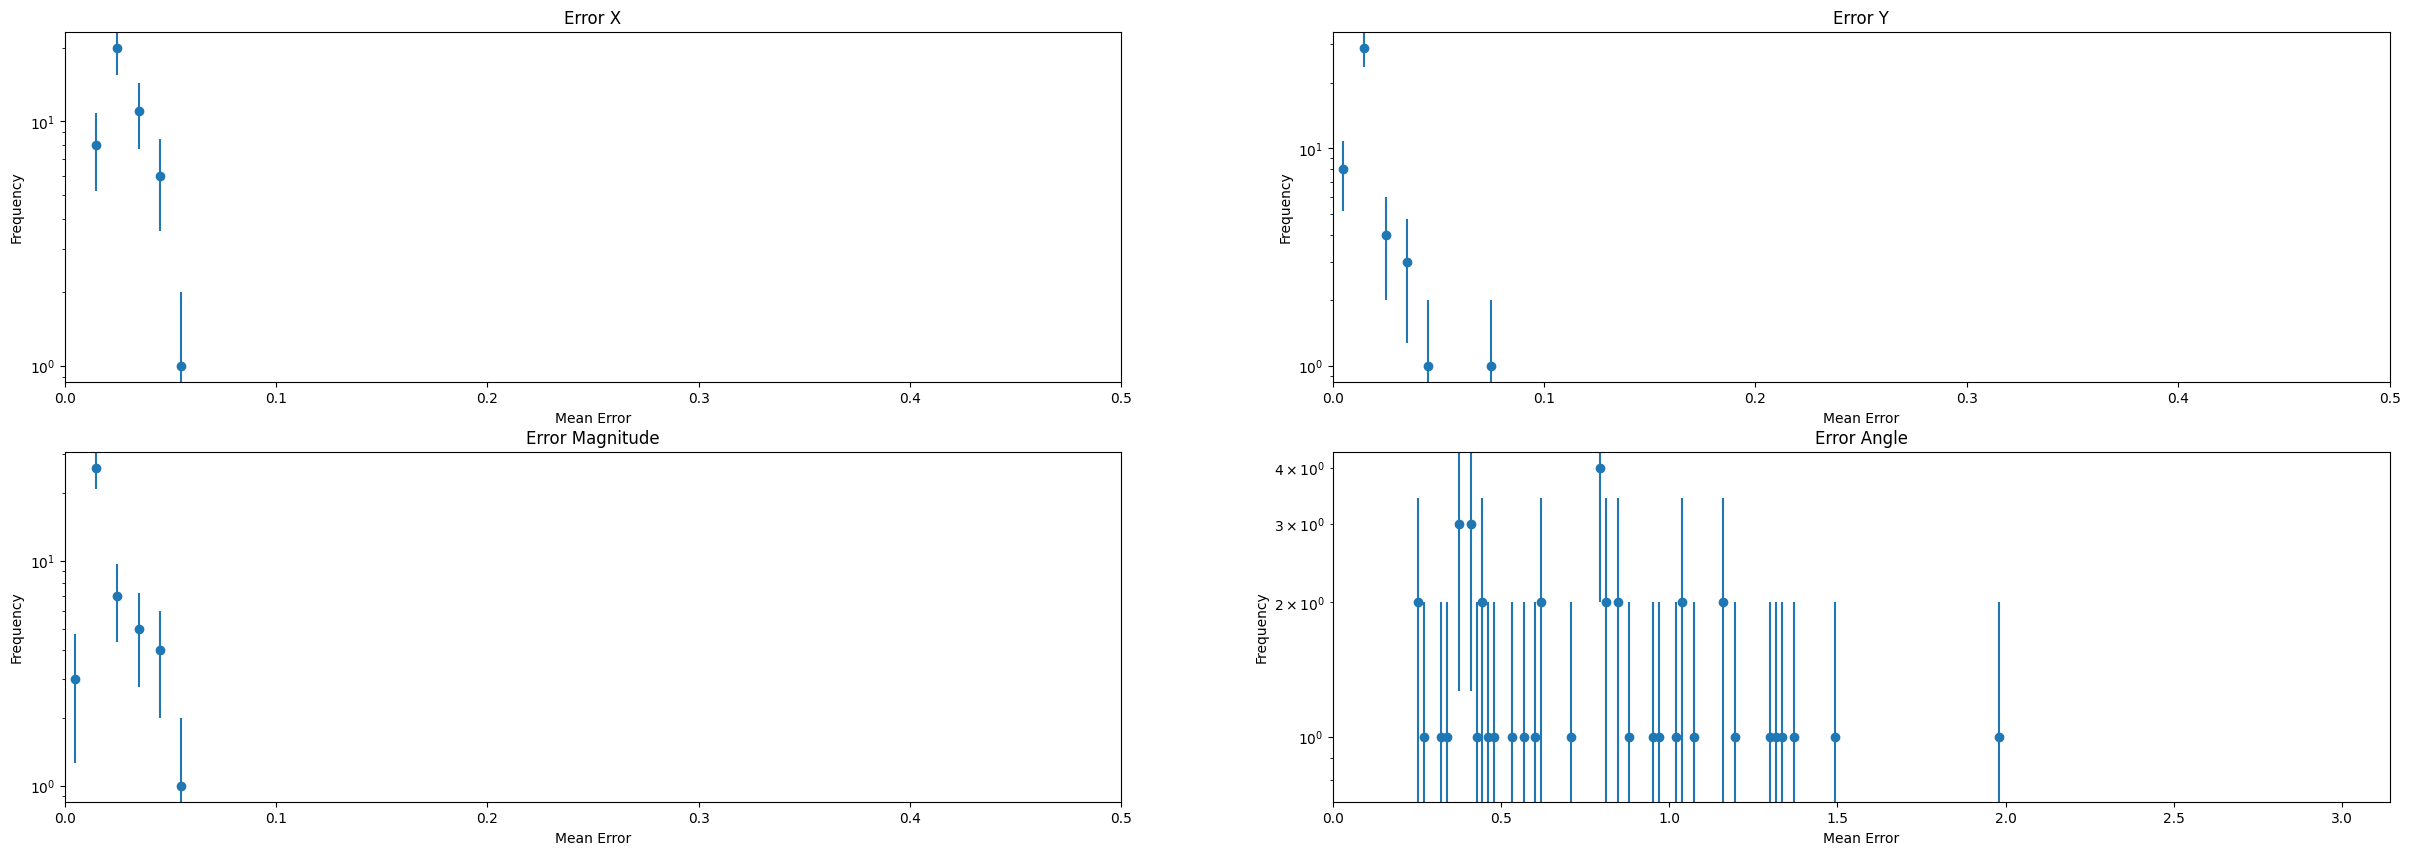

perc95  error x: 0.02881484680667357
perc95  error y: 0.016732170476335222
perc95  error magnitude: 0.021588341591110366
perc95  error angle: 0.7721231842818463
-------------------------
rest


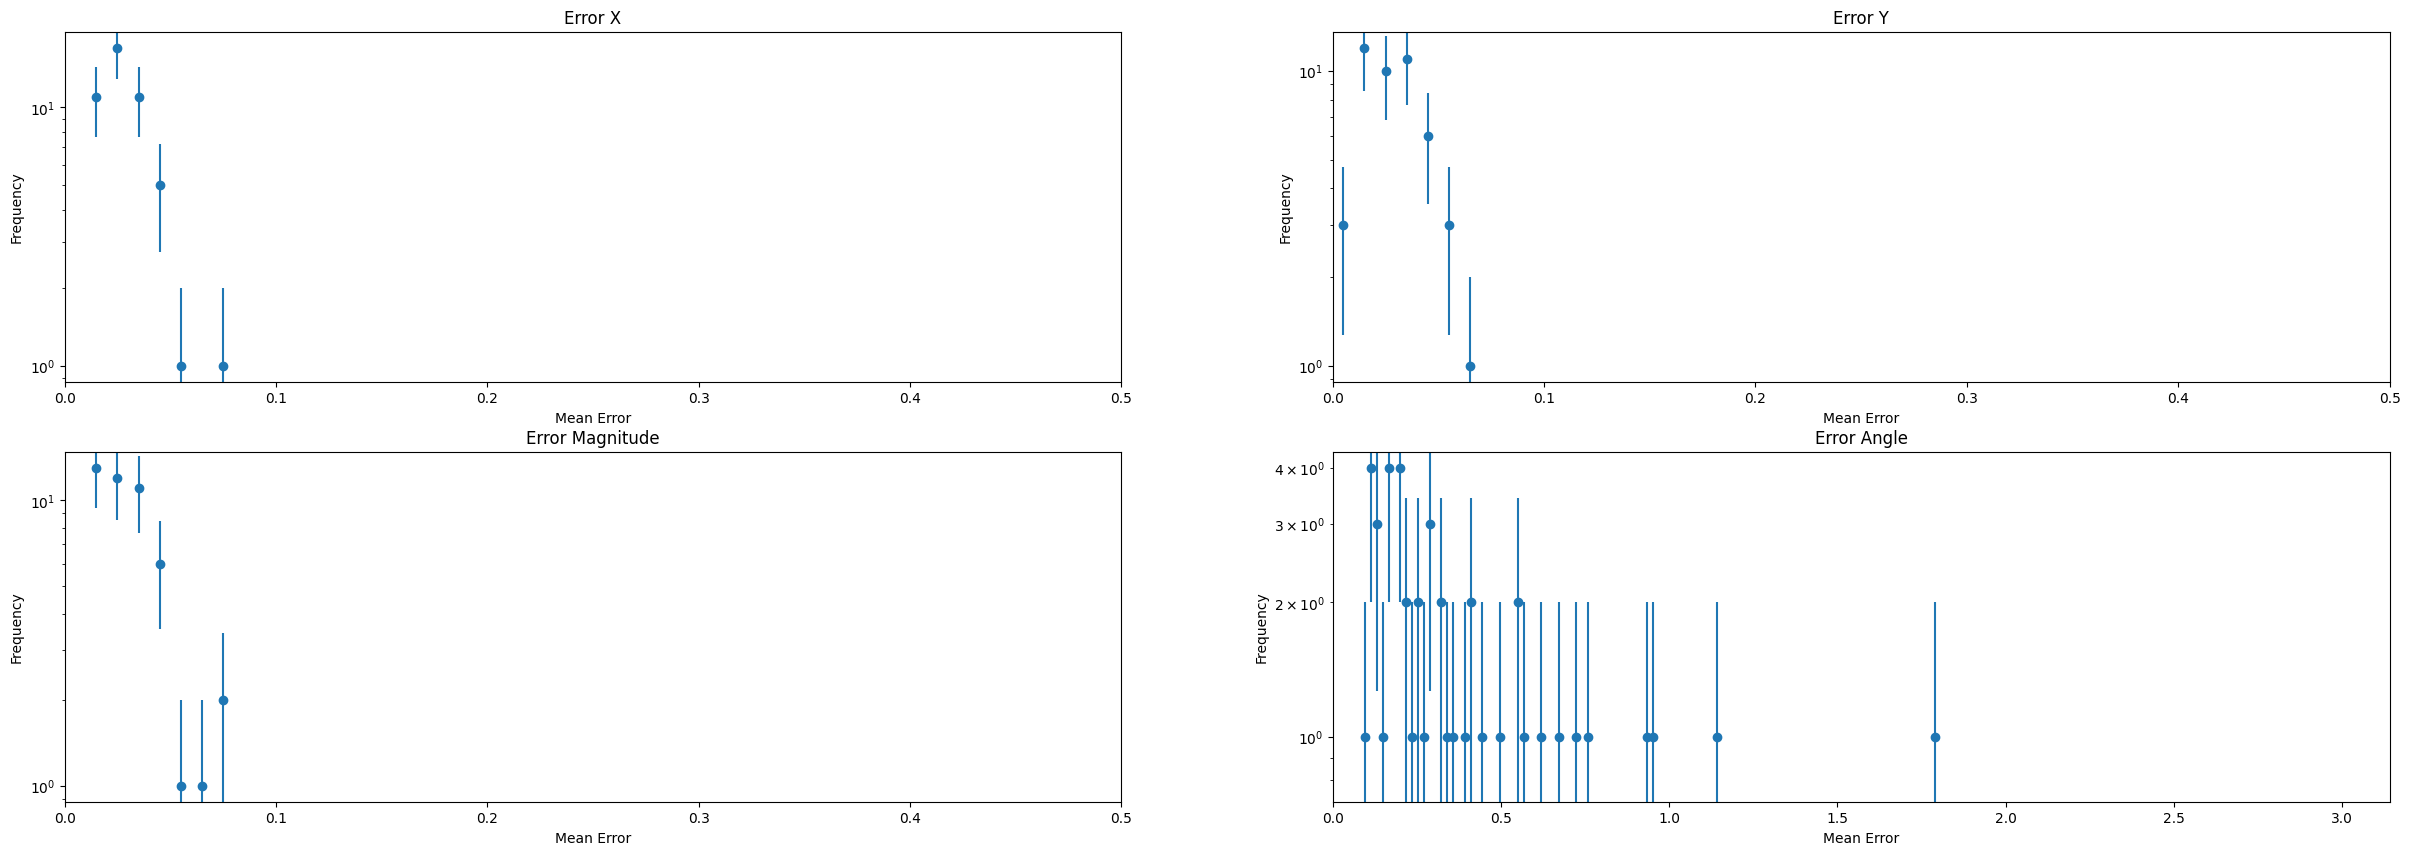

perc95  error x: 0.029449981250597727
perc95  error y: 0.02919769194280809
perc95  error magnitude: 0.031033862902499407
perc95  error angle: 0.38221094167750796


In [13]:
# 95th percentile
getErrorHistograms(model, test_loader, figureOfMerit="all", metric="perc95")
getErrorHistograms(model, test_loader, figureOfMerit="aperture", metric="perc95")
getErrorHistograms(model, test_loader, figureOfMerit="yoke", metric="perc95")
getErrorHistograms(model, test_loader, figureOfMerit="coil", metric="perc95")
getErrorHistograms(model, test_loader, figureOfMerit="rest", metric="perc95")

-------------------------
aperture


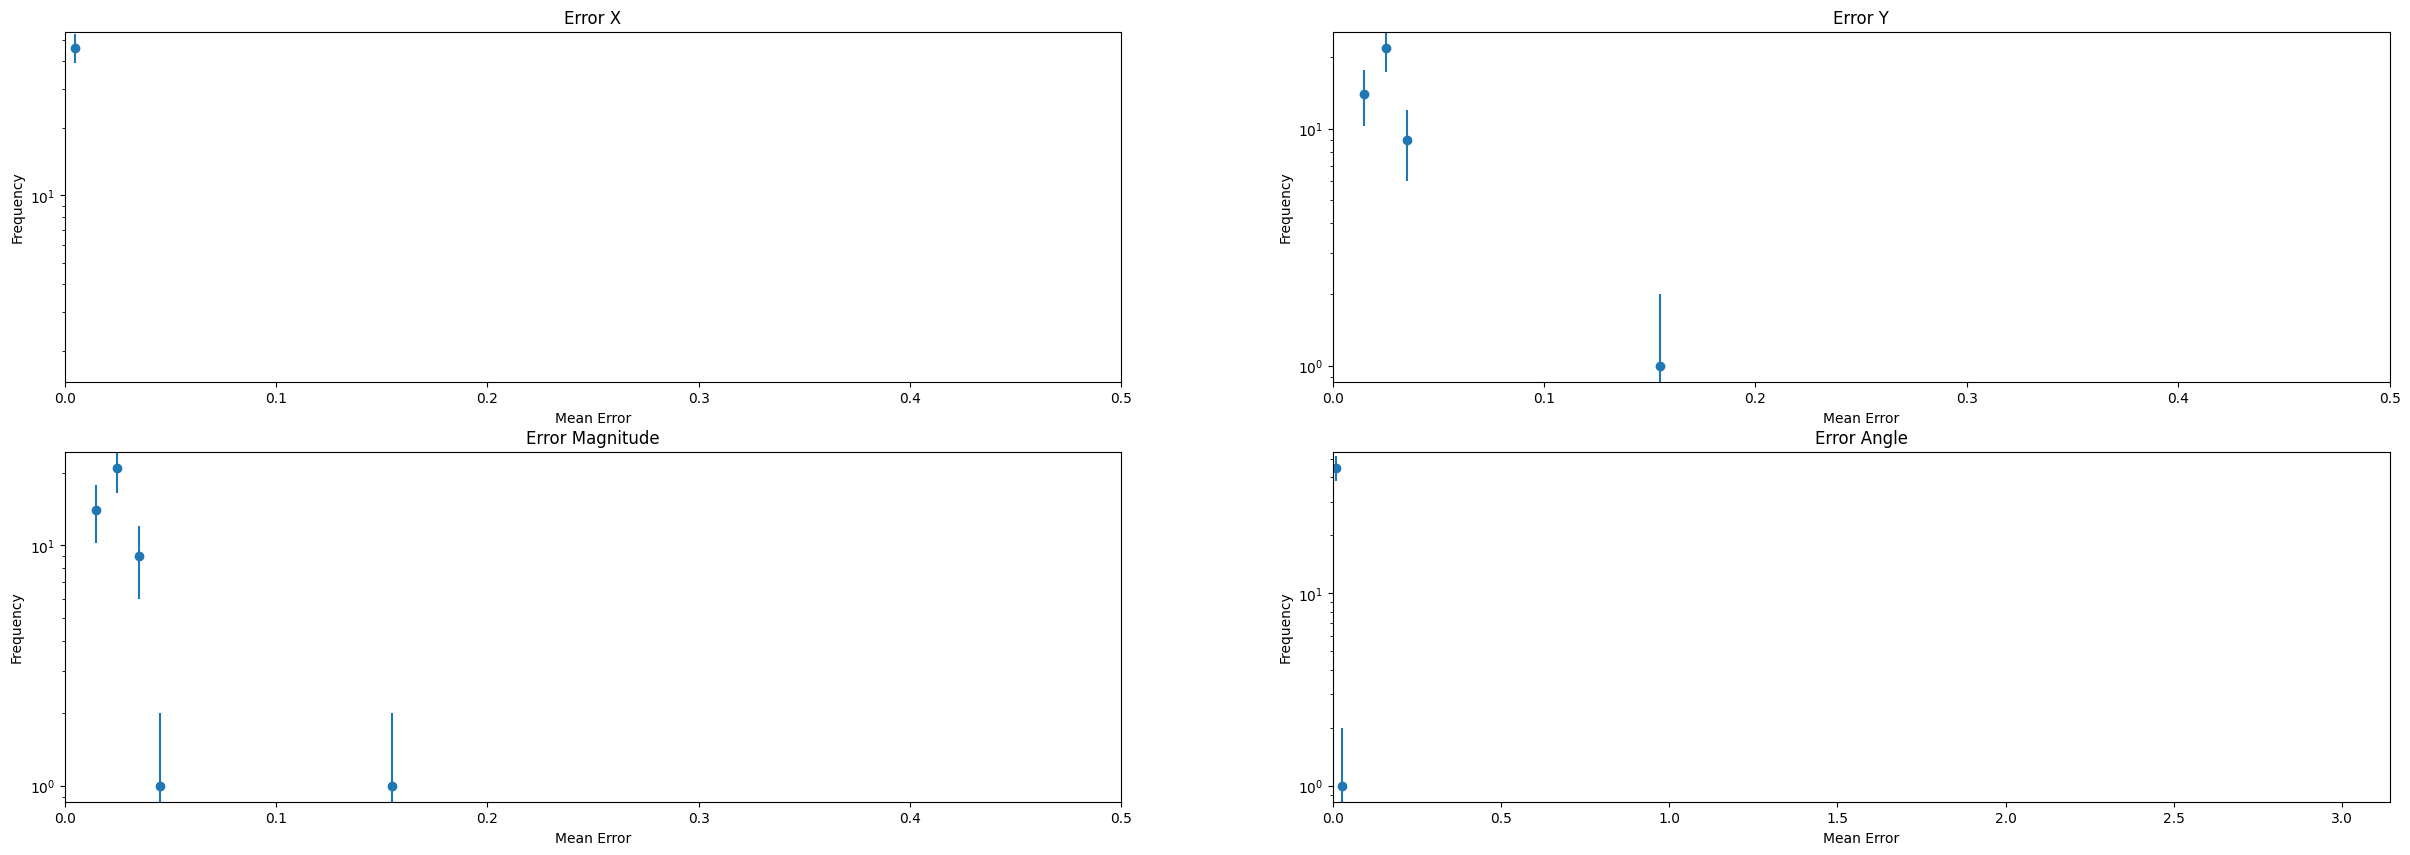

mean  error x: 0.0
mean  error y: 0.026895981
mean  error magnitude: 0.027247893
mean  error angle: 0.0034586082
-------------------------
aperture


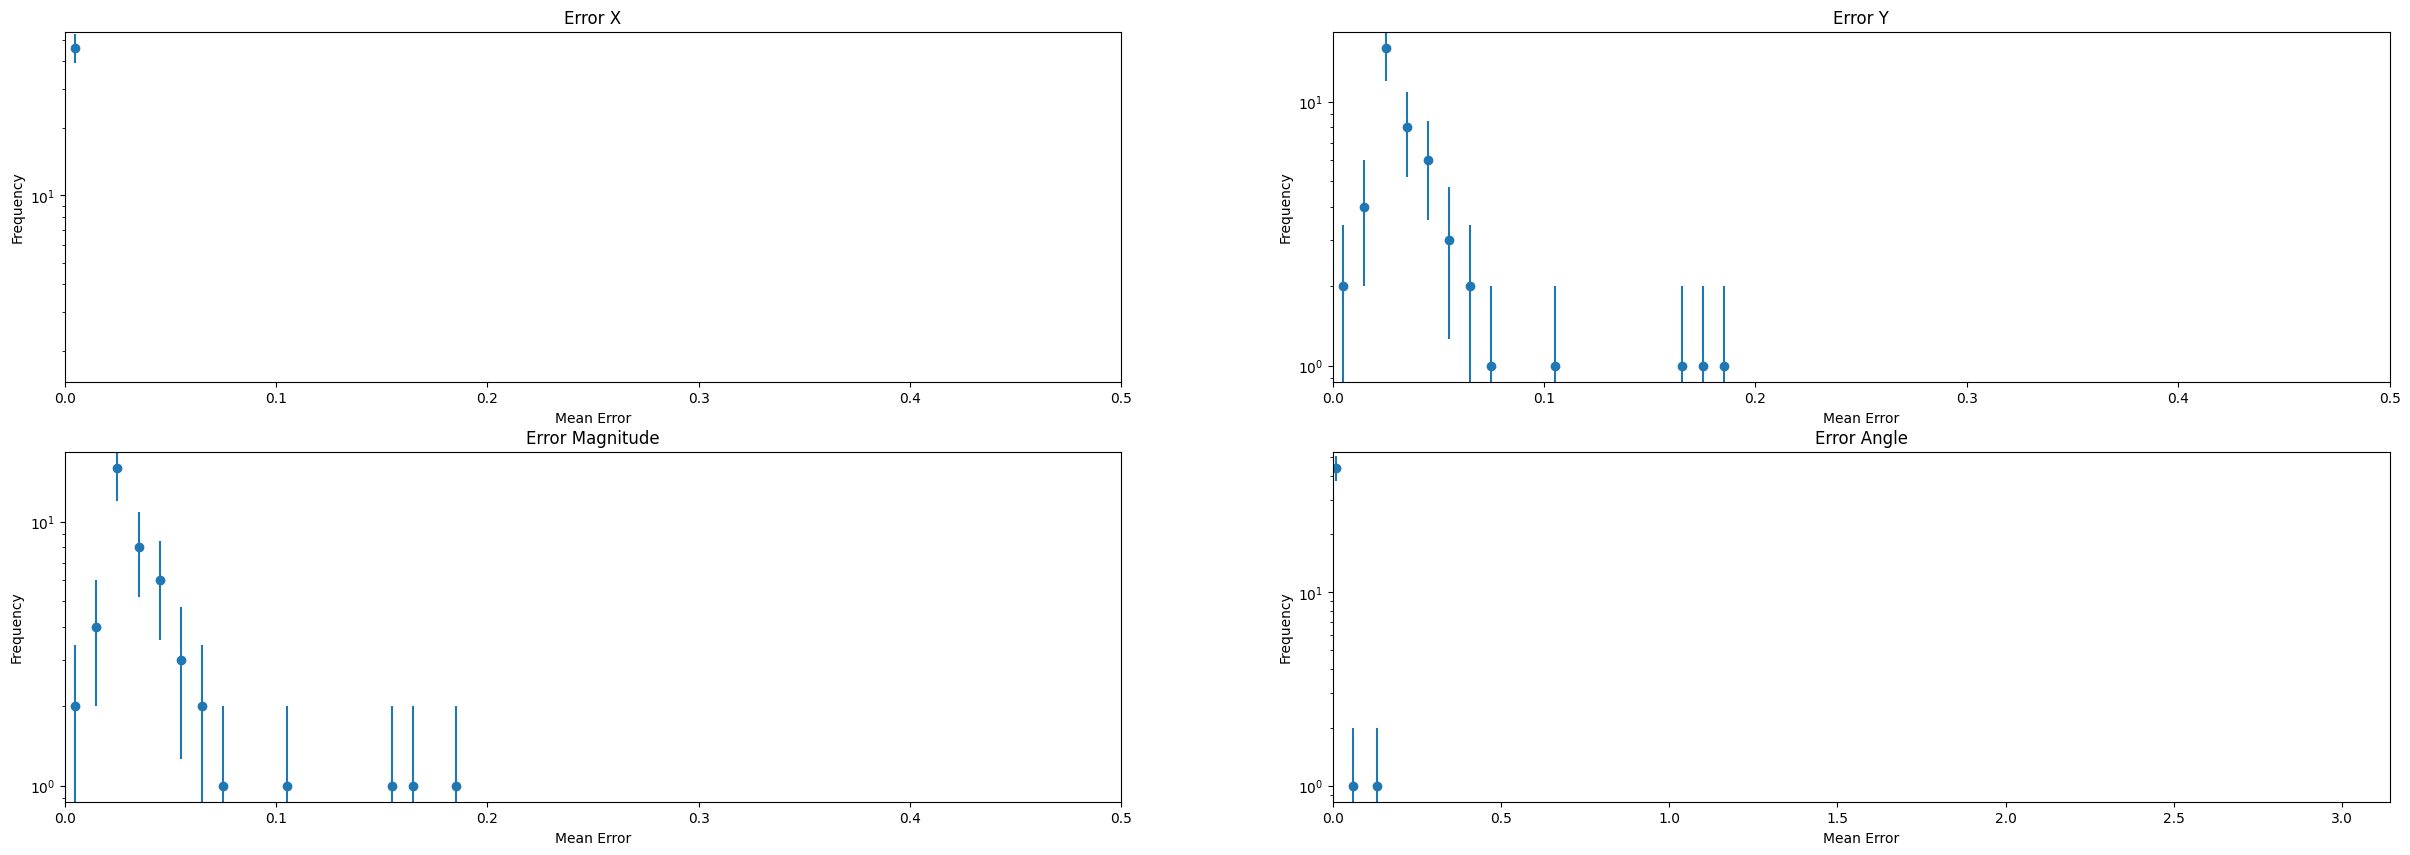

max  error x: 0.0
max  error y: 0.04440562
max  error magnitude: 0.043899562
max  error angle: 0.008310461


In [14]:
# mean and max of aperture for normalization to field in 0,0
getErrorHistograms(model, test_loader, figureOfMerit="aperture", metric="mean", norm="zero")
# getErrorHistograms(model, test_loader, figureOfMerit="aperture", metric="max", norm="zero")
getErrorHistograms(model, test_loader, figureOfMerit="aperture", metric="max", norm="zeroonly")

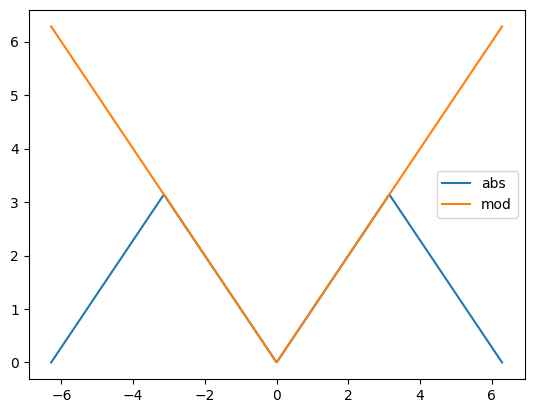

In [15]:
x = np.linspace(-2*np.pi, 2*np.pi, 628)
# get distance to any multiple of pi from any direction
y1 = abs((x + np.pi) % (2*np.pi) - np.pi)
# change to degree
y3 = np.abs(x)

plt.plot(x, y1, label="abs")
# plt.plot(x, y2, label="deg")
plt.plot(x, y3, label="mod")
plt.legend()
plt.show()

In [16]:
# load errors.pkl into a dictionary
with open("../errors.pkl", "rb") as f:
    error_dict = pickle.load(f)
print(error_dict.keys())
print(error_dict["aperture"].keys())
print(len(error_dict["aperture"]["x"]))

dict_keys(['aperture', 'magnet', 'outer'])
dict_keys(['x', 'y', 'mag', 'ang'])
66


aperture
Mean error x: 2.099520399570465
Mean error y: 2.1953653504593036
Mean error magnitude: 3.060611666767371
Mean error angle: 0.8852507207649095
Mean error x std: 0.46914292131225405
Mean error y std: 0.45502320083872133
Mean error magnitude std: 0.6540246782194338
Mean error angle std: 0.1330755260587568


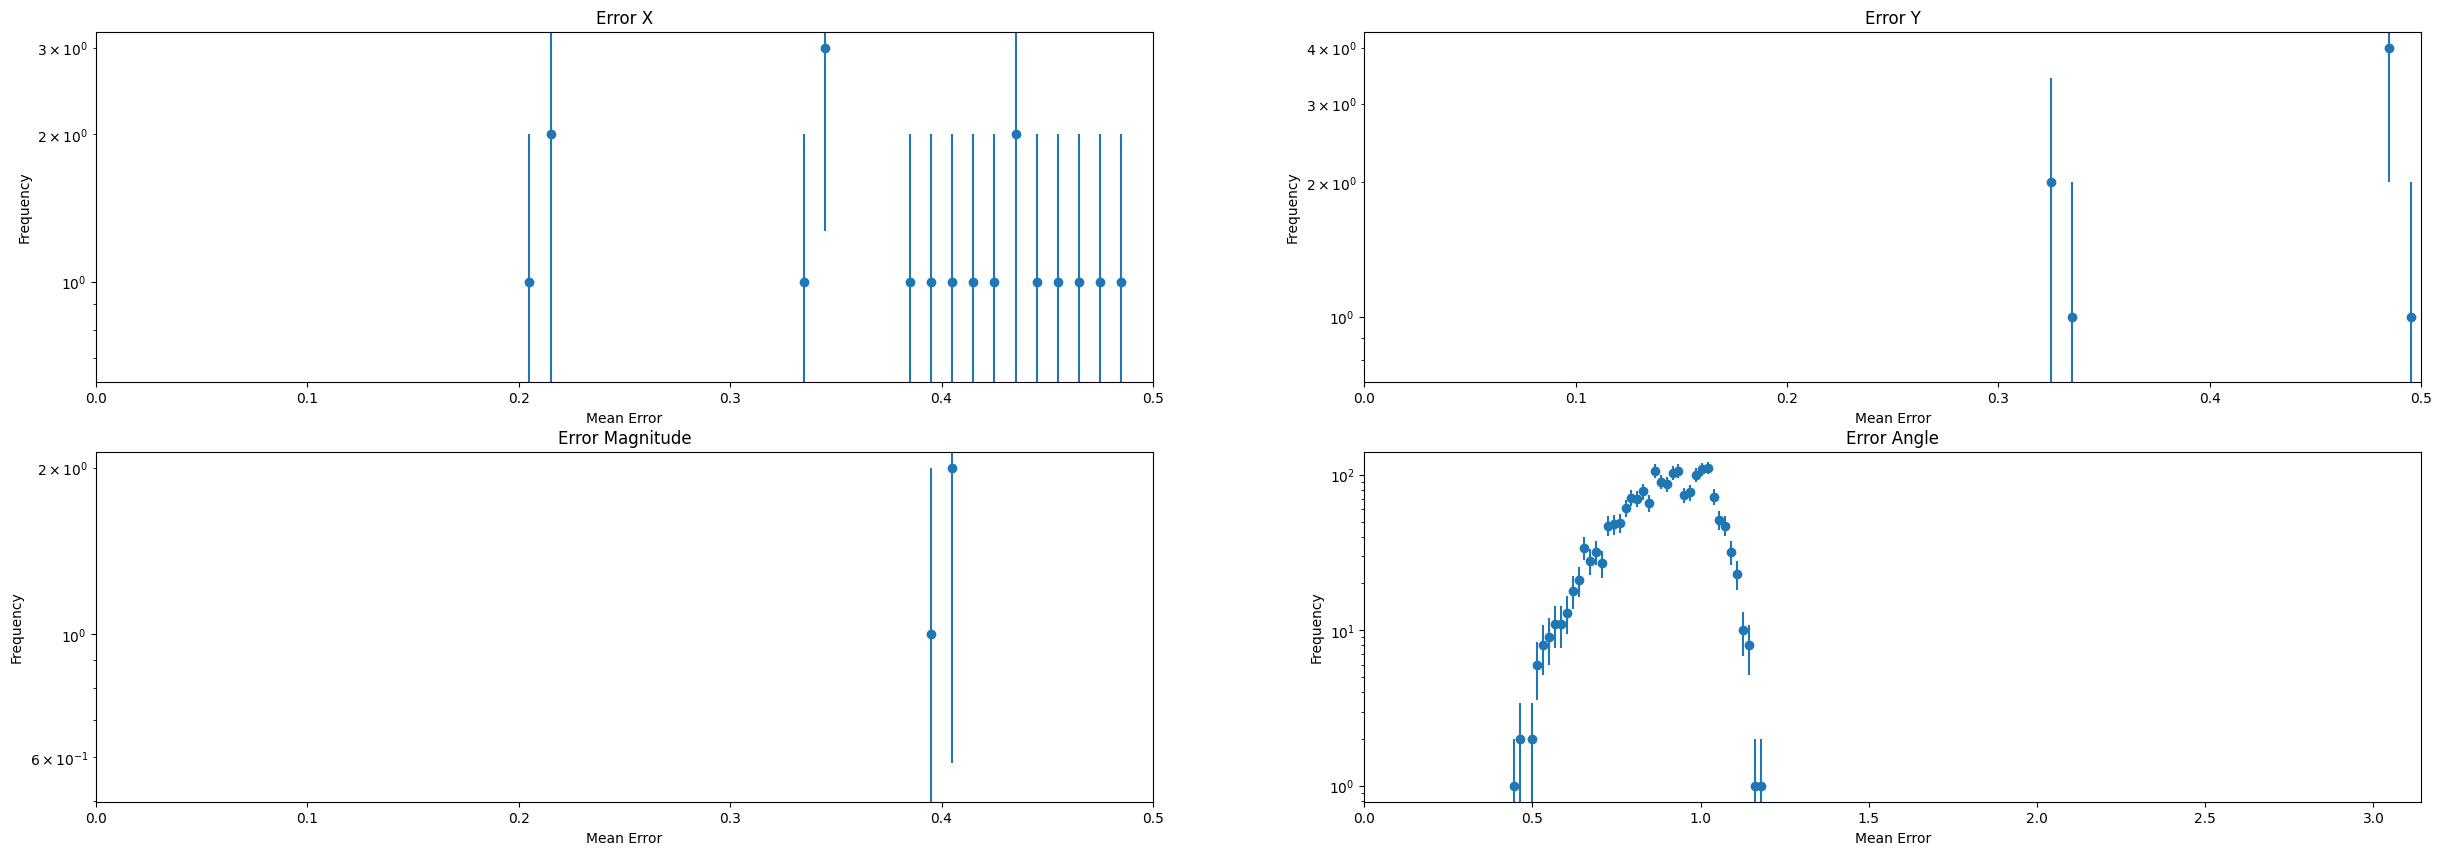

magnet
Mean error x: 2.099520399570465
Mean error y: 2.1953653504593036
Mean error magnitude: 3.060611666767371
Mean error angle: 0.8852507207649095
Mean error x std: 0.46914292131225405
Mean error y std: 0.45502320083872133
Mean error magnitude std: 0.6540246782194338
Mean error angle std: 0.1330755260587568


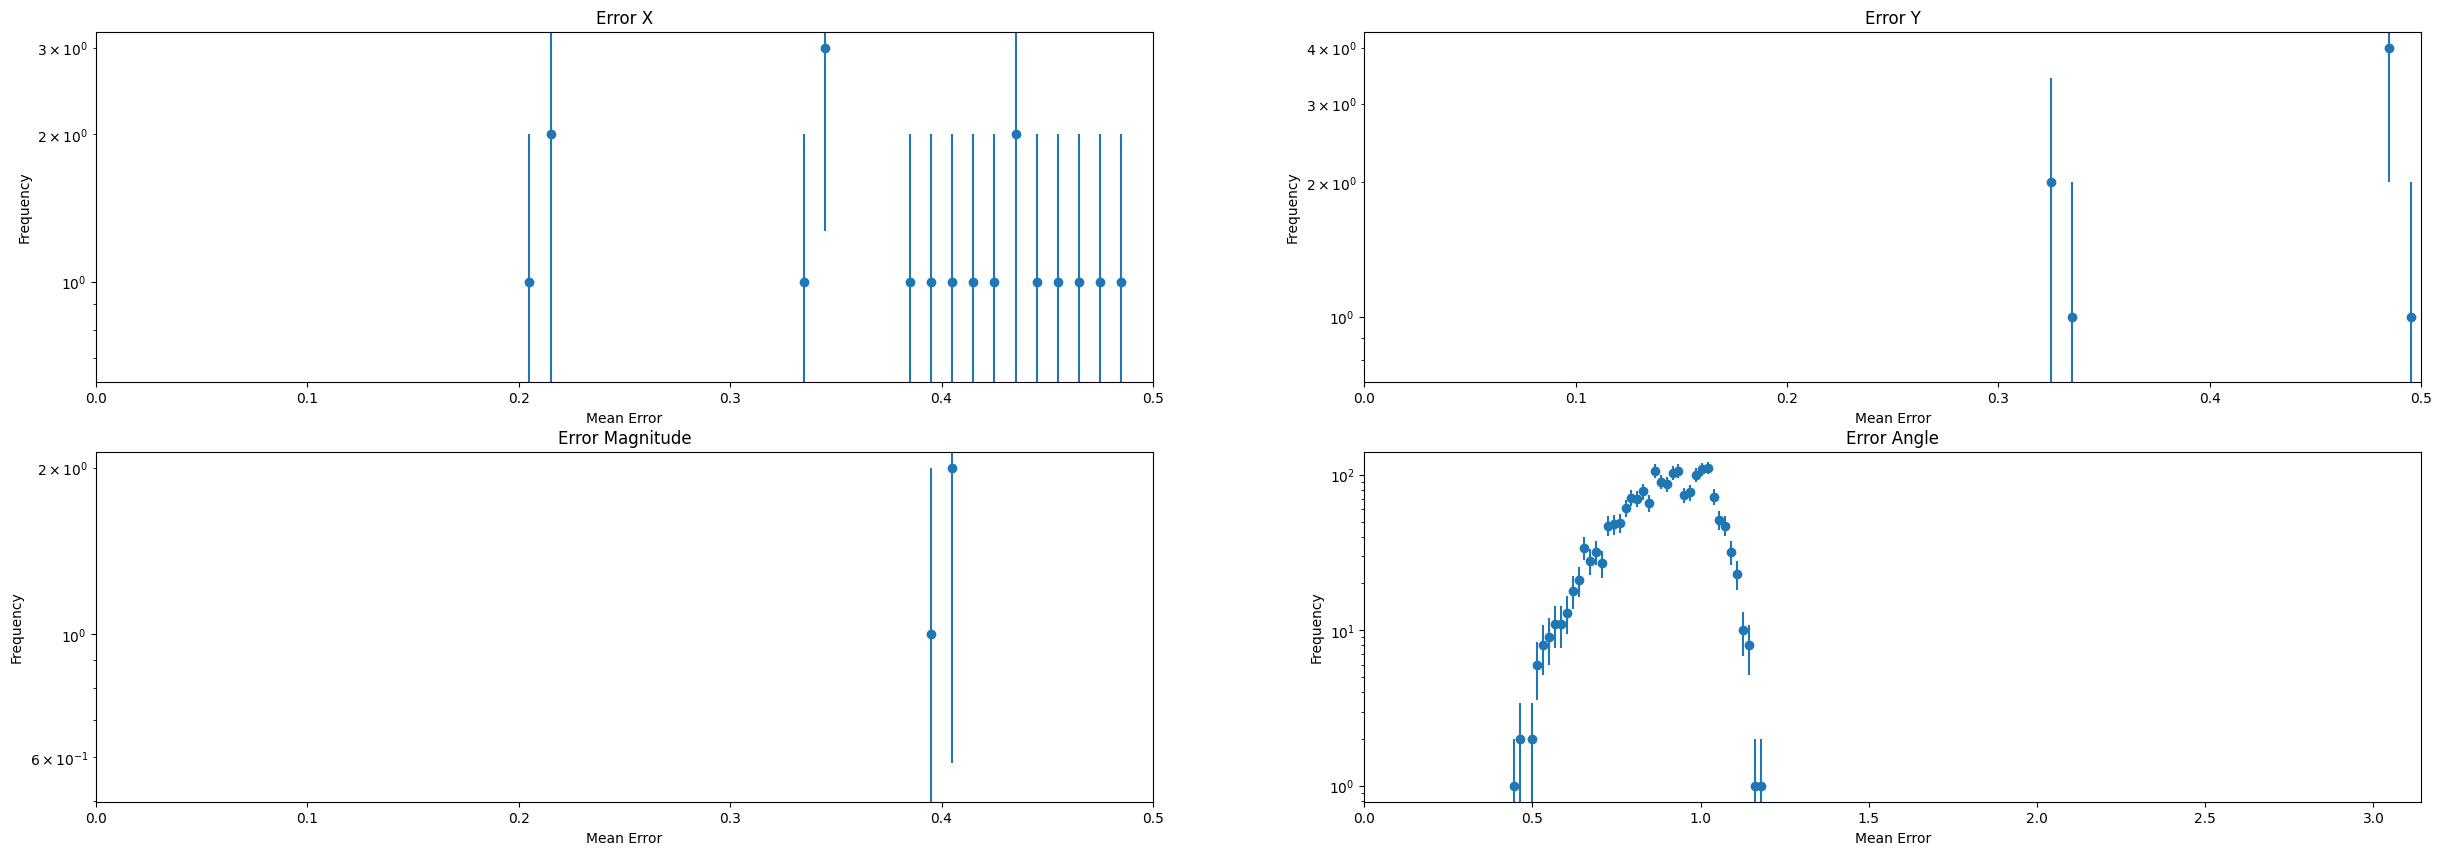

outer
Mean error x: 2.099520399570465
Mean error y: 2.1953653504593036
Mean error magnitude: 3.060611666767371
Mean error angle: 0.8852507207649095
Mean error x std: 0.46914292131225405
Mean error y std: 0.45502320083872133
Mean error magnitude std: 0.6540246782194338
Mean error angle std: 0.1330755260587568


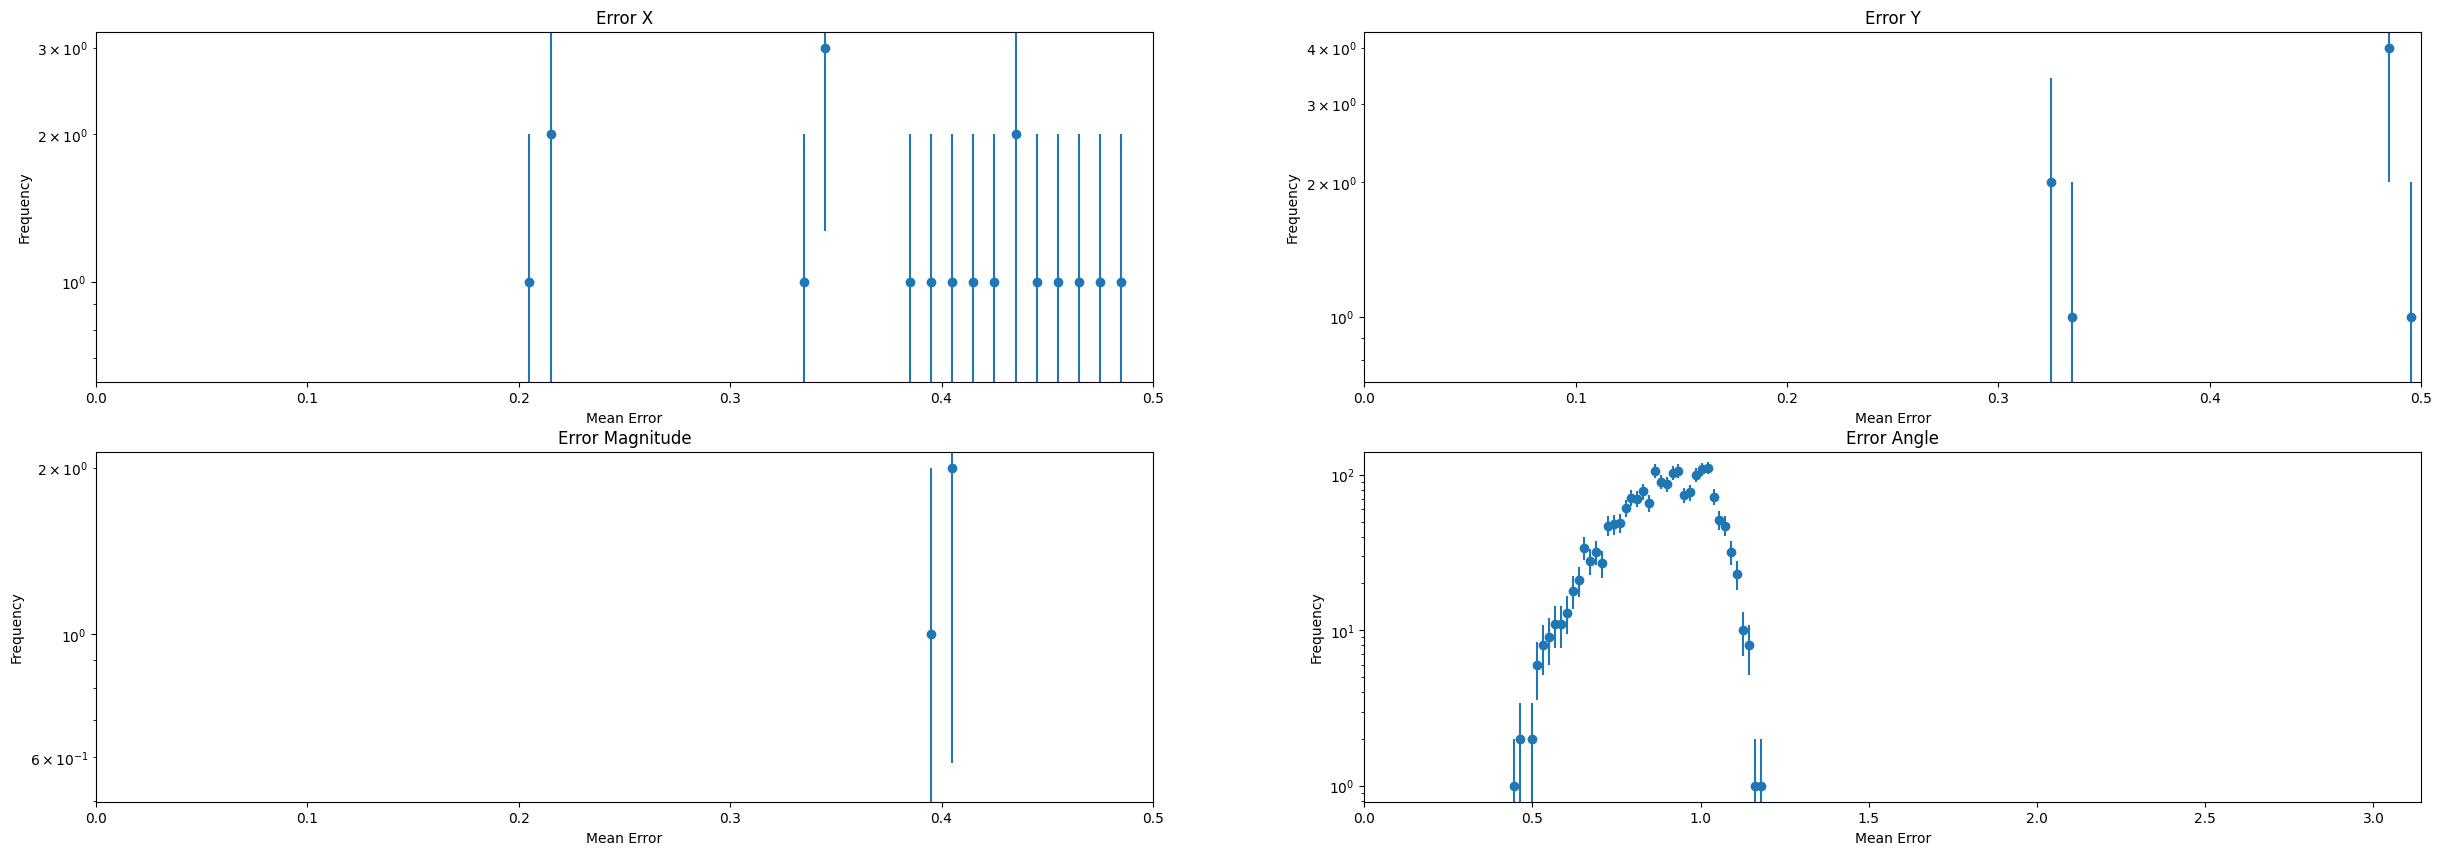

In [17]:
#plot the aperture errors
key = "aperture"
i = -1
if True:
# for i in range(len(error_dict["aperture"]["x"])):
    for key in error_dict.keys():
        error_x = error_dict[key]["x"][i]
        error_y = error_dict[key]["y"][i]
        error_mag = error_dict[key]["mag"][i]
        error_ang = error_dict[key]["ang"][i]
        print(key)
        print("Mean error x:", np.mean(error_x))
        print("Mean error y:", np.mean(error_y))
        print("Mean error magnitude:", np.mean(error_mag))
        print("Mean error angle:", np.mean(error_ang))
        print("Mean error x std:", np.std(error_x))
        print("Mean error y std:", np.std(error_y))
        print("Mean error magnitude std:", np.std(error_mag))
        print("Mean error angle std:", np.std(error_ang))
        plot_histograms(error_x, error_y, error_mag, error_ang)

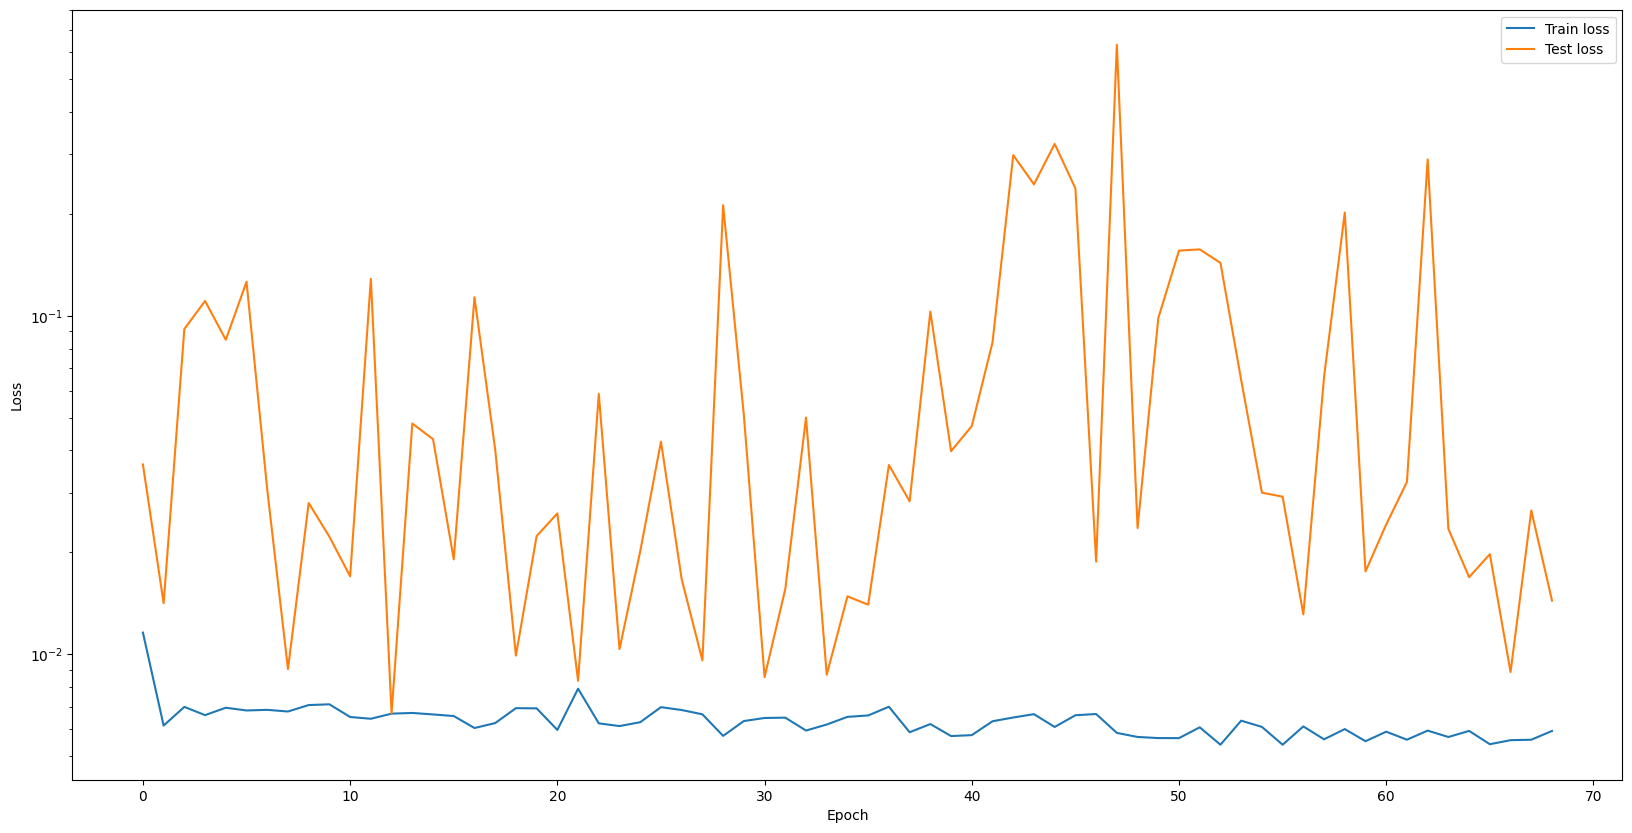

In [18]:
# load train_hist.pkl and test_hist.pkl and plot the loss
with open("../train_hist.pkl", "rb") as f:
    train_hist = pickle.load(f)
with open("../test_hist.pkl", "rb") as f:
    test_hist = pickle.load(f)

# train test split
split = (0.9, 0.1)

fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot(np.array(train_hist)/split[0], label="Train loss")
ax.plot(np.array(test_hist)/split[1], label="Test loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_yscale("log")
ax.legend()
plt.show()


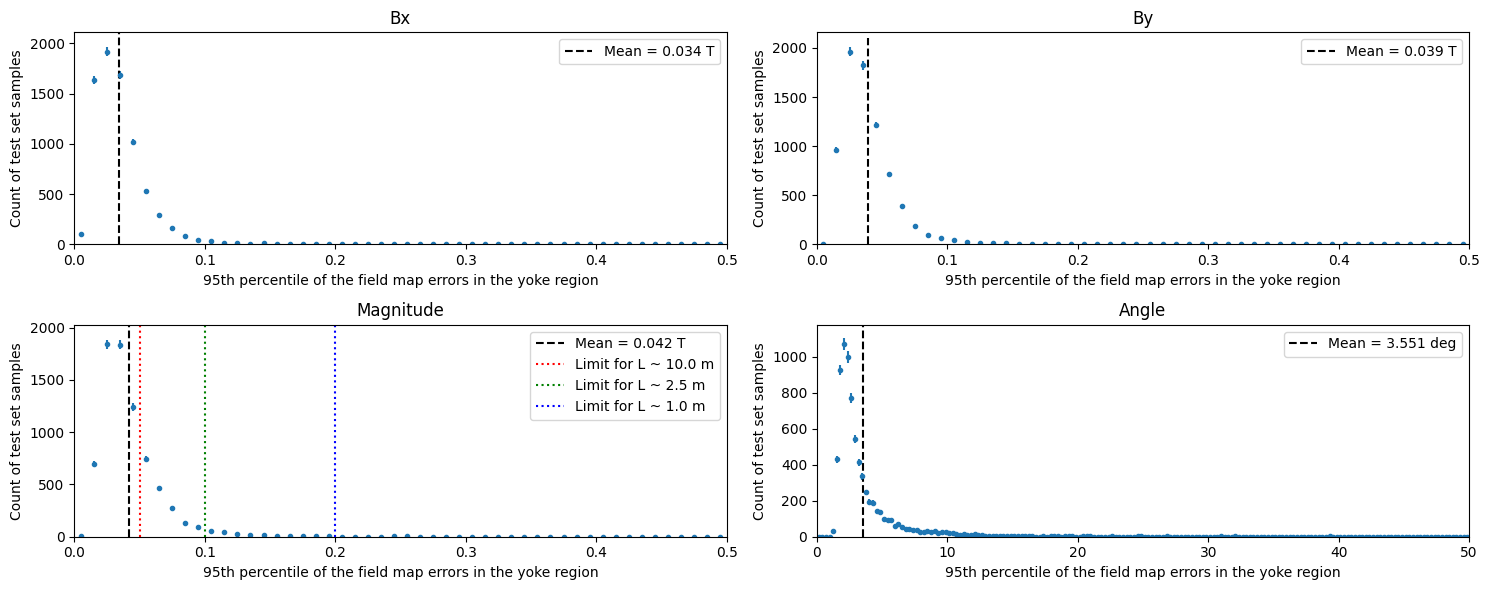

In [19]:
error_x, error_y, error_mag, error_ang = pickle.load(open("errors_yoke.pkl", "rb"))

# plot_histograms(error_x, error_y, error_mag, error_ang)
# metric = "perc95"
# print(metric, " error x:", np.mean(error_x))
# print(metric, " error y:", np.mean(error_y))
# print(metric, " error magnitude:", np.mean(error_mag))
# print(metric, " error angle:", np.mean(error_ang))

def plot_histogram(ax, data, title, bins, range, unit, addlimits=False):
    ax.set_xlim(range)
    counts, bin_edges = np.histogram(data, bins=bins, range=range)
    ax.set_title(title)
    ax.set_xlabel(r"95th percentile of the field map errors in the yoke region")
    ax.set_ylabel("Count of test set samples")
    # ax.set_yscale("log")
    bin_centres = (bin_edges[:-1] + bin_edges[1:]) * 0.5
    err = np.sqrt(counts)
    ymax = 1.1*np.max(counts)

    ax.errorbar(bin_centres, counts, yerr=err, fmt='.')
    ax.vlines(np.mean(data), 0, 2100, color='k', label="Mean = " + str(np.round(np.mean(data), 3)) + " " + unit, linestyle='--')
    if addlimits:
        ax.vlines(0.05, 0, ymax, color='r', label="Limit for L ~ 10.0 m", linestyle=':')
        ax.vlines(0.1, 0, ymax, color='g', label="Limit for L ~ 2.5 m", linestyle=':')
        ax.vlines(0.2, 0, ymax, color='b', label="Limit for L ~ 1.0 m", linestyle=':')
    ax.set_ylim(0, ymax)
    ax.legend()

def plot_histograms(error_x, error_y, error_mag, error_ang):
    fig, ax = plt.subplots(2, 2, figsize=(15, 6))
    plot_histogram(ax[0, 0], error_x, "Bx", 50, (0, 0.5), "T")
    plot_histogram(ax[0, 1], error_y, "By", 50, (0, 0.5), "T")
    plot_histogram(ax[1, 0], error_mag, "Magnitude", 50, (0, 0.5), "T", addlimits=True)
    plot_histogram(ax[1, 1], error_ang*180/np.pi, "Angle", 180, (0, 50), "deg")
    fig.tight_layout()
    fig.savefig("errors_yoke_perc95.png")
    fig.savefig("errors_yoke_perc95.pdf")
    plt.show()

plot_histograms(error_x, error_y, error_mag, error_ang)
